## 导入库

In [12]:
# 基础数据处理和可视化
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']


# 机器学习相关
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_california_housing

# 深度学习相关
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# XGBoost相关
import xgboost as xgb

# 超参数优化
import optuna
from optuna.samplers import TPESampler

# 其他工具
from datetime import datetime, timedelta
import os
import joblib

# 自定义模块
from plot import *
from process_read import *
from calculate import *

def pearson_correlation_coefficient(y_true, y_pred):
    """计算皮尔逊相关系数"""
    # 使用 numpy 的 corrcoef 函数
    return np.corrcoef(y_true, y_pred)[0, 1]

## 读取数据

### 读取预测气象数据

In [4]:
result = collect_filename(r'E:\USTC_New_Past\USTC_Now_Predict','WP4_33.20N-115.96E_')

file_paths = result
# print(file_paths)

dfs = [pd.read_csv(file, header=0,names=['time','height','predicted_speed','predicted_direction','predicted_temperature','predicted_humidity',
        'predicted_pressure']) for file in file_paths]

# 初始化一个空的 DataFrame 来存储第1天的数据
first_day_data = pd.DataFrame()

# 遍历每个 DataFrame 并筛选第1天的数据
for df in dfs:
    # 将 'time' 列转换为 datetime 类型
    df['time'] = pd.to_datetime(df['time'])

    # 找到最小的时间点作为第一天的开始
    min_time = df['time'].min()

    first_day_start = min_time
    first_day_end  = first_day_start + timedelta(days=1)

    first_day_df =  df[(df['time'] >= first_day_start) & (df['time'] < first_day_end)]
    first_day_data = pd.concat([first_day_data, first_day_df], ignore_index=True)

# 将时间列转换为datetime类型
first_day_data['time'] = pd.to_datetime(first_day_data['time'], errors='coerce')

# 获取所有唯一的高度值
heights = first_day_data['height'].unique()

# 创建一个以时间为索引的新DataFrame
merged_data = pd.DataFrame()
merged_data['time'] = first_day_data['time'].unique()
merged_data.set_index('time', inplace=True)

# 对每个高度，提取相应的数据并添加到新DataFrame中
for height in heights:
    # 筛选特定高度的数据
    height_data = first_day_data[first_day_data['height'] == height].copy()
    height_data.set_index('time', inplace=True)
    
    # 添加带有高度后缀的列
    merged_data[f'wind_speed_{int(height)}m'] = height_data['predicted_speed']
    merged_data[f'wind_direction_{int(height)}m'] = height_data['predicted_direction']
    merged_data[f'temperature_{int(height)}m'] = height_data['predicted_temperature']
    merged_data[f'humidity_{int(height)}m'] = height_data['predicted_humidity']
    merged_data[f'pressure_{int(height)}m'] = height_data['predicted_pressure']

# 重置索引，使时间成为一个列
merged_data.reset_index(inplace=True)

# 按时间排序
merged_data.sort_values('time', inplace=True)

# 显示结果
merged_data

time  wind_speed_10m  wind_direction_10m  \
0     2023-09-02 00:00:00        1.339142          166.852342   
1     2023-09-02 00:15:00        1.341748          167.863005   
2     2023-09-02 00:30:00        1.418785          170.551408   
3     2023-09-02 00:45:00        1.464852          174.065008   
4     2023-09-02 01:00:00        1.491219          177.643057   
...                   ...             ...                 ...   
53467 2025-03-11 22:45:00        0.918181          295.166212   
53468 2025-03-11 23:00:00        1.047048          294.039456   
53469 2025-03-11 23:15:00        1.089509          289.708734   
53470 2025-03-11 23:30:00        1.022861          281.799935   
53471 2025-03-11 23:45:00        0.855386          269.176427   

       temperature_10m  humidity_10m  pressure_10m  wind_speed_30m  \
0            20.093469     85.103010   1007.200234        2.476784   
1            20.112970     85.013420   1007.031797        2.452872   
2            20.188867     84.594960   1006.921172        2.440811   
3            20.127618     84.897340   1006.837734        2.397959   
4            20.091974     85.040924   1006.732969        2.378135   
...                ...           ...           ...             ...   
53467        14.915216     81.039460   1011.817109        0.926929   
53468        14.683588     82.303810   1011.896328        1.203782   
53469        14.425531     83.630070   1011.936484        1.372839   
53470        14.232538     84.556725   1011.893750        1.385948   
53471        14.109399     85.046850   1011.804453        1.269888   

       wind_direction_30m  temperature_30m  humidity_30m  ...  \
0              156.559356        22.467676     73.243980  ...   
1              157.739011        22.592645     72.592680  ...   
2              159.876915        22.638574     72.379005  ...   
3              162.506784        22.585962     72.676940  ...   
4              165.930854        22.530298     72.950836  ...   
...                   ...              ...           ...  ...   
53467          286.399384        16.020532     72.619995  ...   
53468          288.713432        15.907922     73.217920  ...   
53469          285.487294        15.800806     73.700806  ...   
53470          278.152115        15.727533     73.894750  ...   
53471          266.751300        15.689722     73.814380  ...   

       wind_speed_110m  wind_direction_110m  temperature_110m  humidity_110m  \
0             5.339846           150.043314         25.791040      57.794770   
1             5.127446           150.487044         25.667963      58.372234   
2             4.938799           151.160255         25.567896      58.759193   
3             4.759709           152.089612         25.479913      59.036380   
4             4.583559           153.352131         25.400293      59.242810   
...                ...                  ...               ...            ...   
53467         0.509766           188.461206         16.800684      63.932705   
53468         0.532665           249.592260         16.713281      64.402084   
53469         0.833923           267.875385         16.634088      64.845180   
53470         0.999243           263.781254         16.587915      65.046844   
53471         1.018525           251.399801         16.570673      65.015045   

       pressure_110m  wind_speed_130m  wind_direction_130m  temperature_130m  \
0         995.778203         5.929283           150.078230         25.878198   
1         995.606719         5.690061           150.311522         25.764856   
2         995.493359         5.487291           150.803801         25.685815   
3         995.407500         5.296605           151.584178         25.621729   
4         995.300703         5.107630           152.694616         25.562646   
...              ...              ...                  ...               ...   
53467    1000.004609         0.552937           179.151764         16.751459   
53468    1000.078

### 读取实测功率数据

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13868\2976006315.py:44: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13868\2976006315.py:44: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13868\2976006315.py:44: UserWarning: Glyph 21151 (\N{CJK UNIFIED IDEOGRAPH-529F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13868\2976006315.py:44: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13868\2976006315.py:44: UserWarning: Glyph 40065 (\N{CJK UNIFIED IDEOGRAPH-9C81}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_138

2023年9月的数据点数量: 2865
2023年10月的数据点数量: 2976
2023年11月的数据点数量: 2789
2023年12月的数据点数量: 2871
2024年1月的数据点数量: 2730
2024年2月的数据点数量: 2777
2024年3月的数据点数量: 2976
2024年4月的数据点数量: 2859
2024年5月的数据点数量: 2976
2024年6月的数据点数量: 2872
2024年7月的数据点数量: 2976
2024年8月的数据点数量: 2976
2024年9月的数据点数量: 2874
2024年10月的数据点数量: 2975
2024年11月的数据点数量: 97


e:\Power_Pre_Model\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Power_Pre_Model\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Power_Pre_Model\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 21151 (\N{CJK UNIFIED IDEOGRAPH-529F}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Power_Pre_Model\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Power_Pre_Model\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
e:\Power_Pre_Model\venv\Lib\site-packages\IPython\core\events.py:82: UserWa

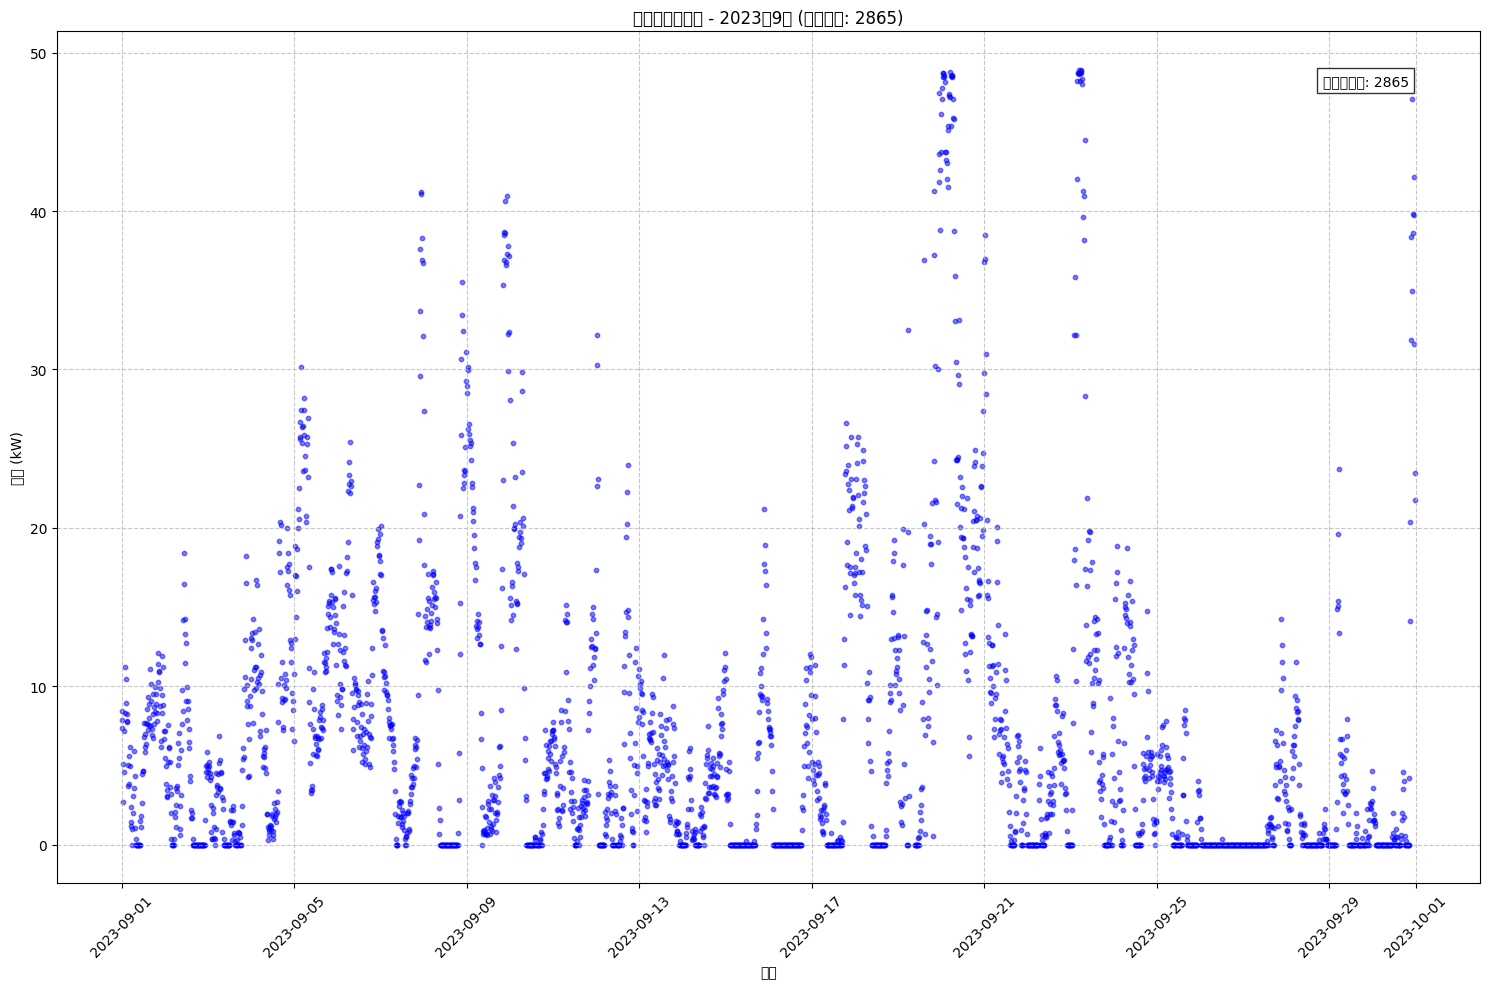

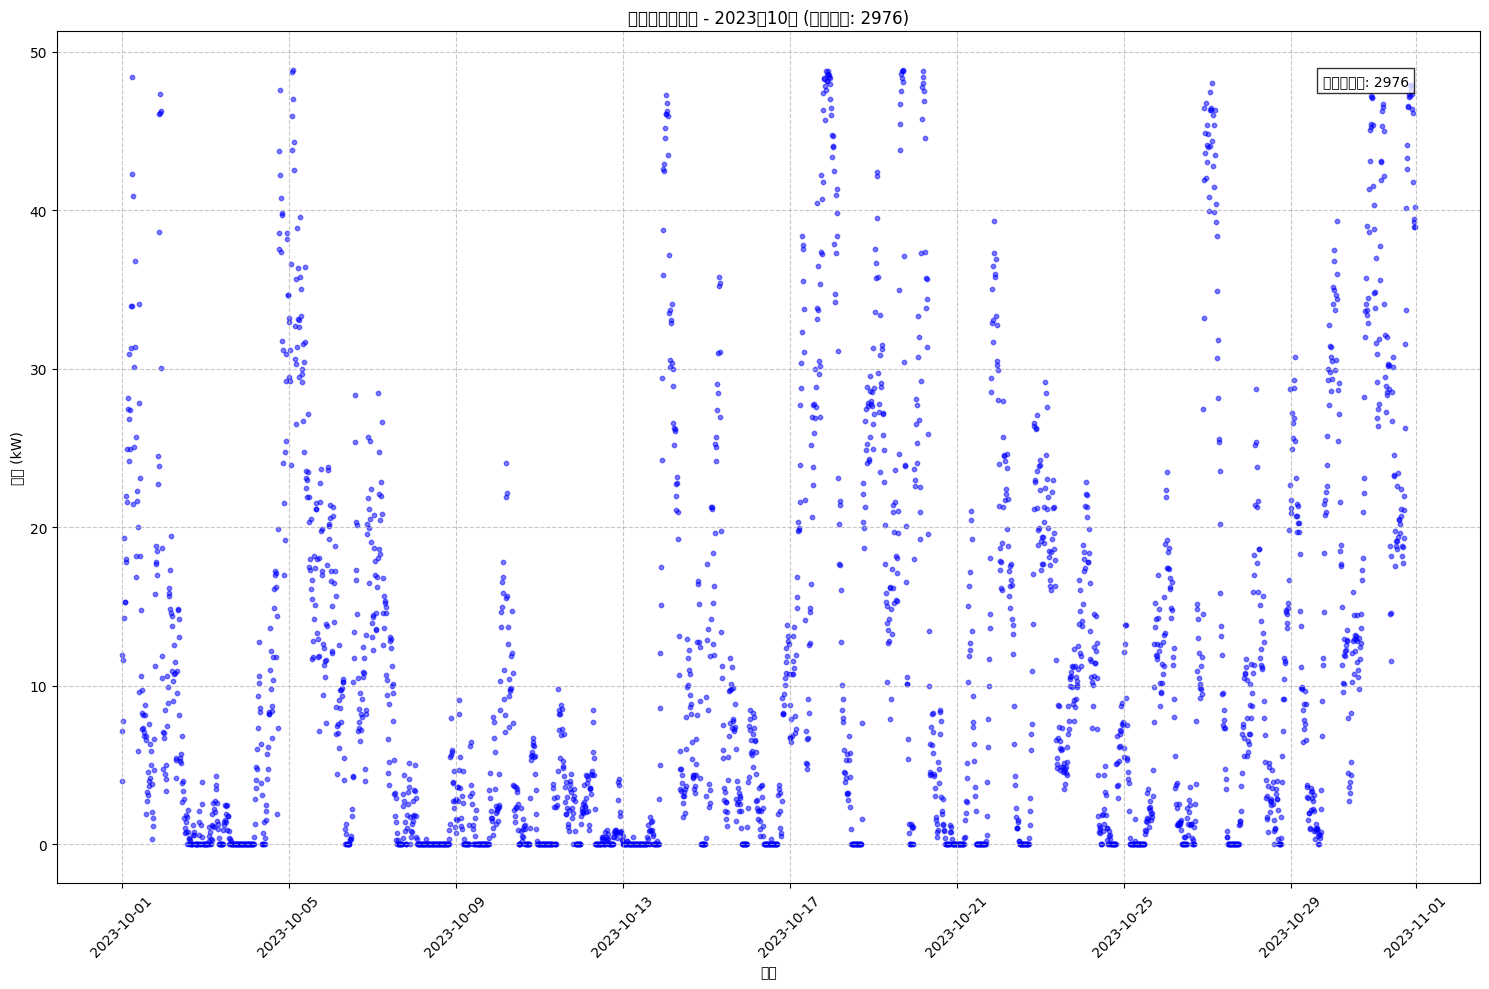

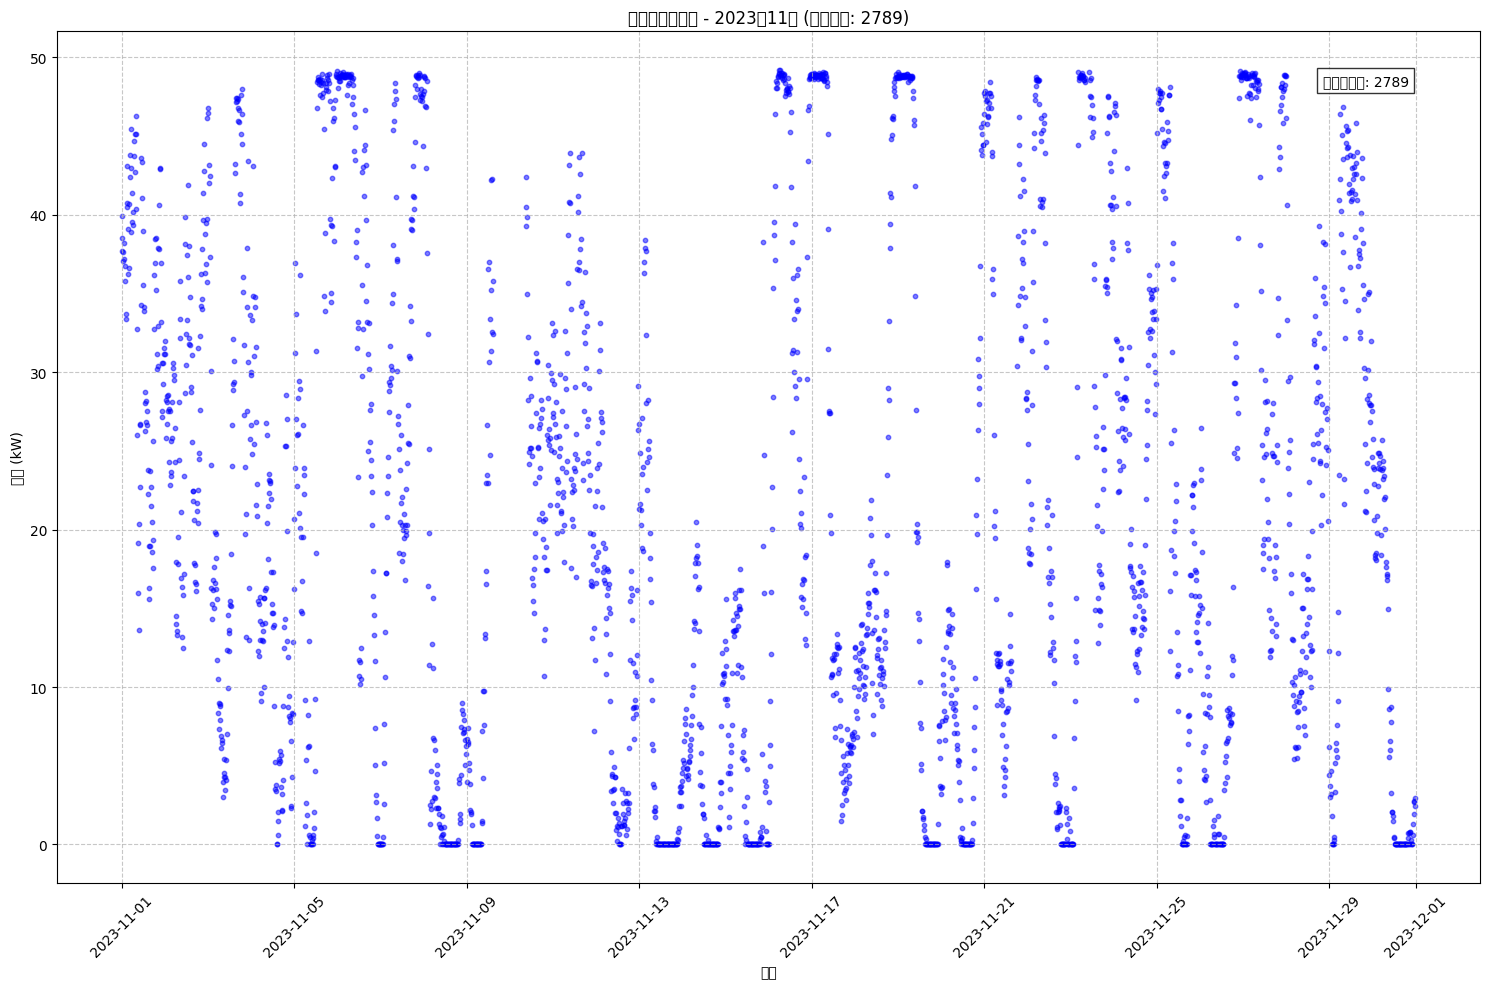

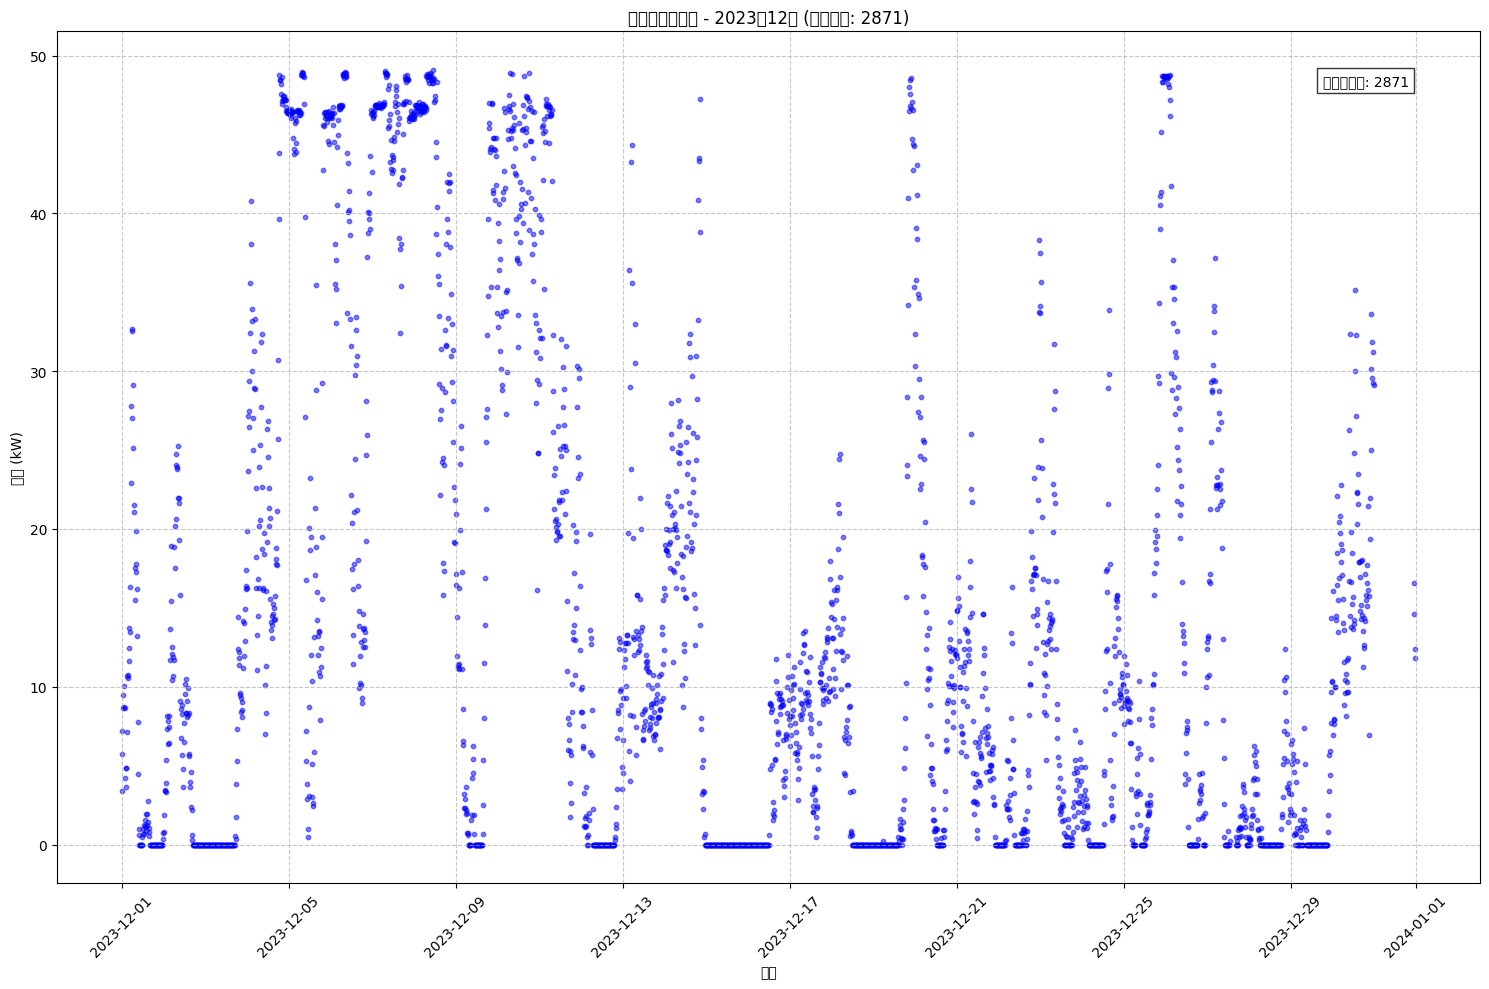

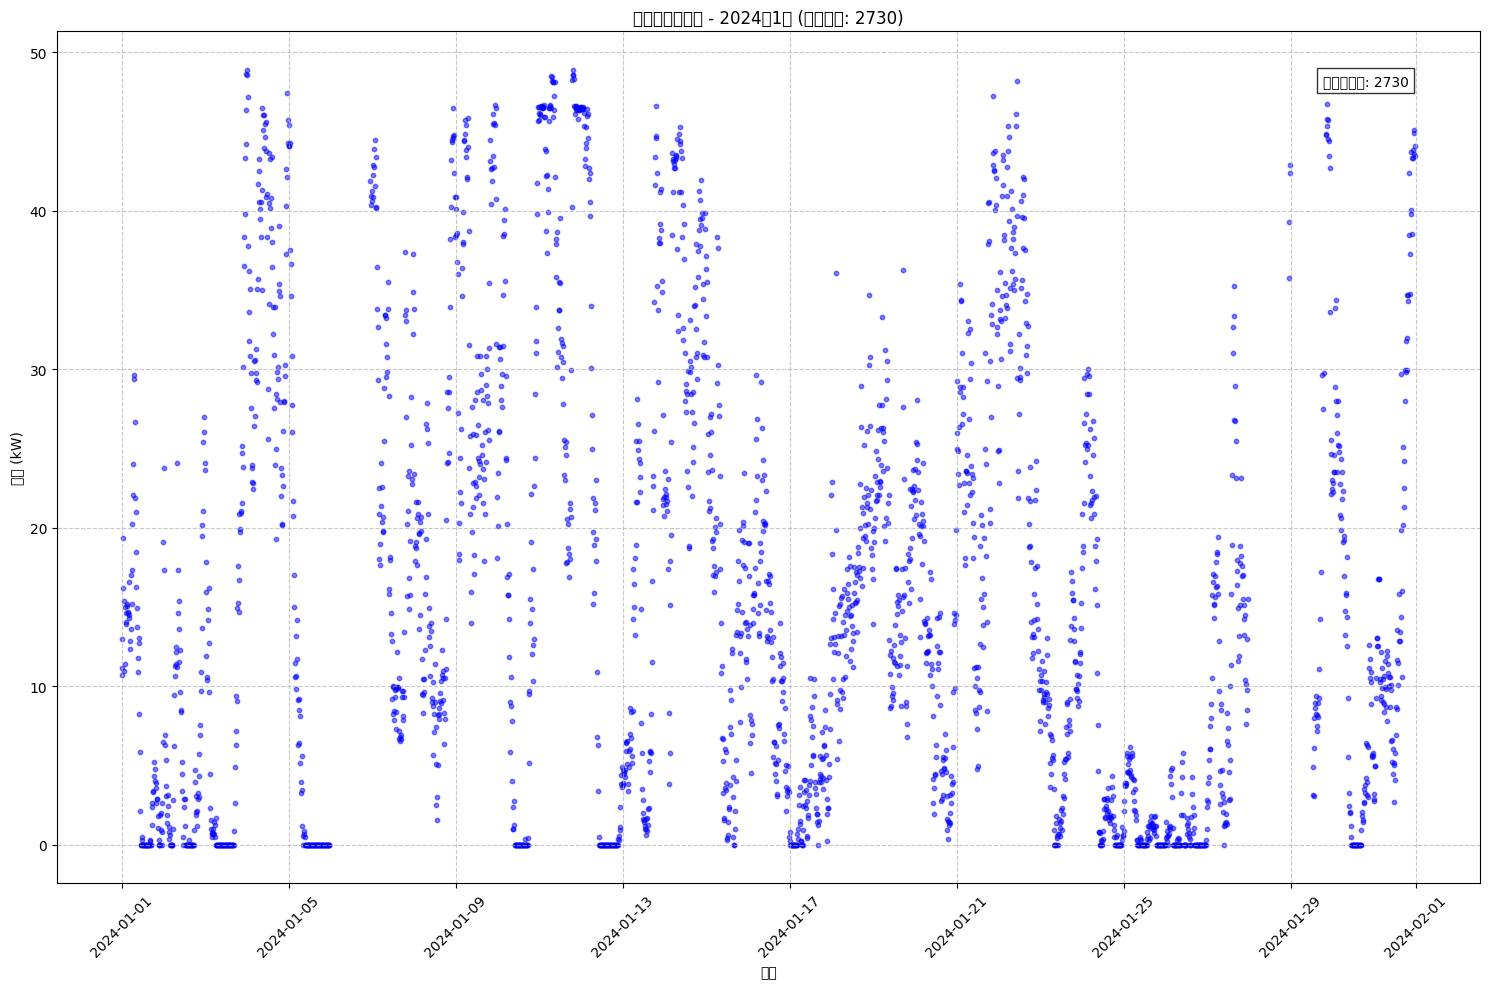

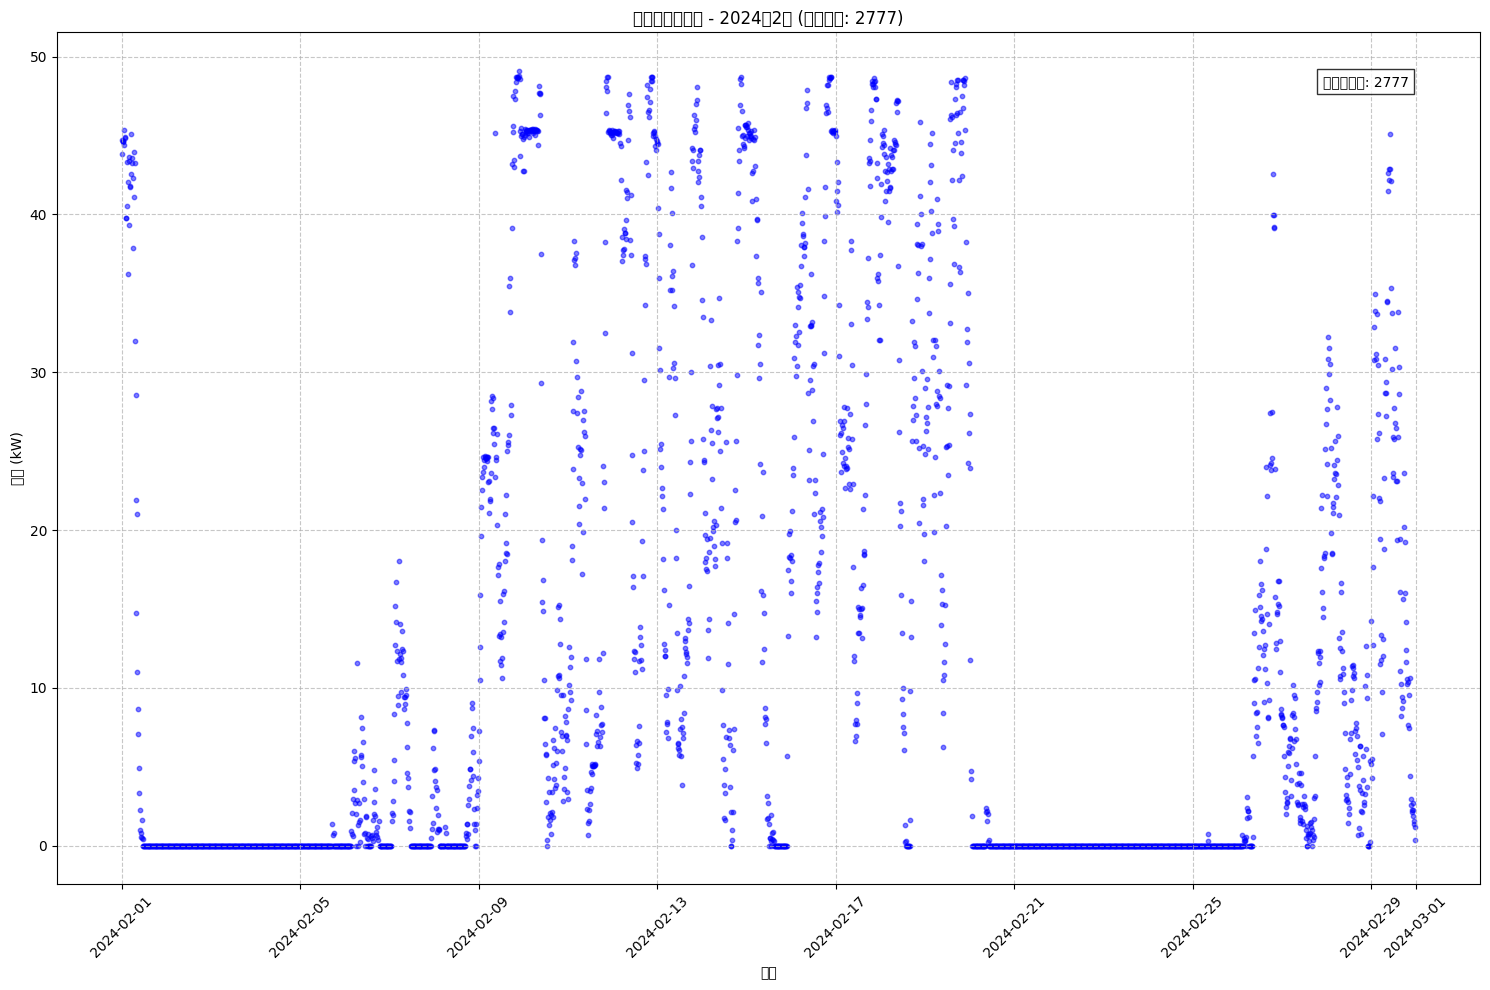

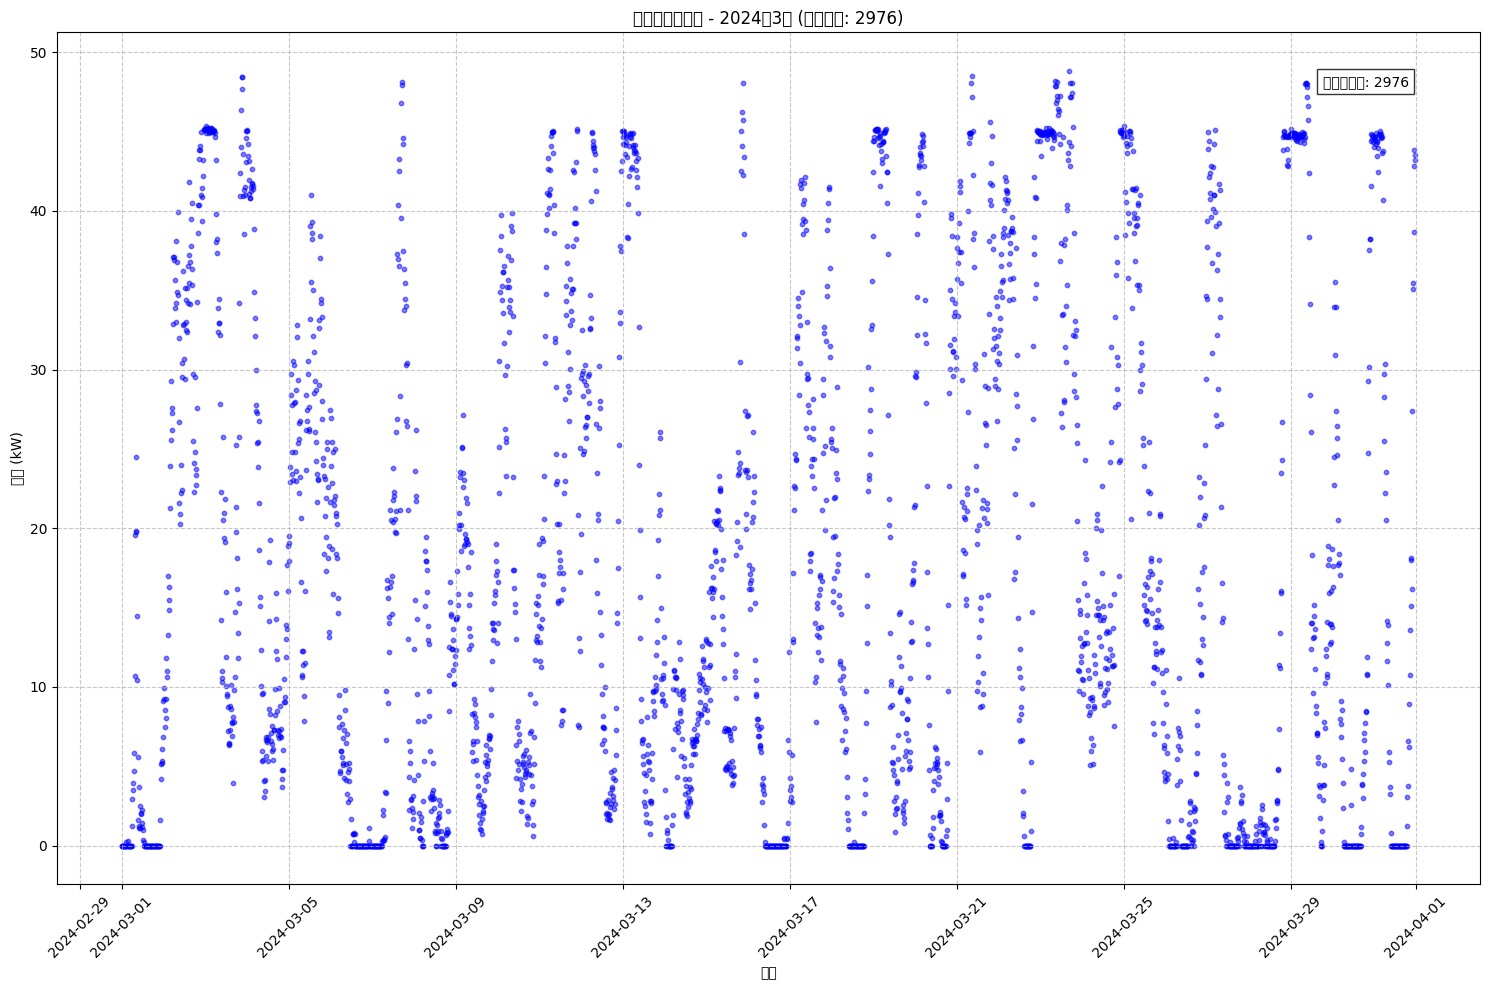

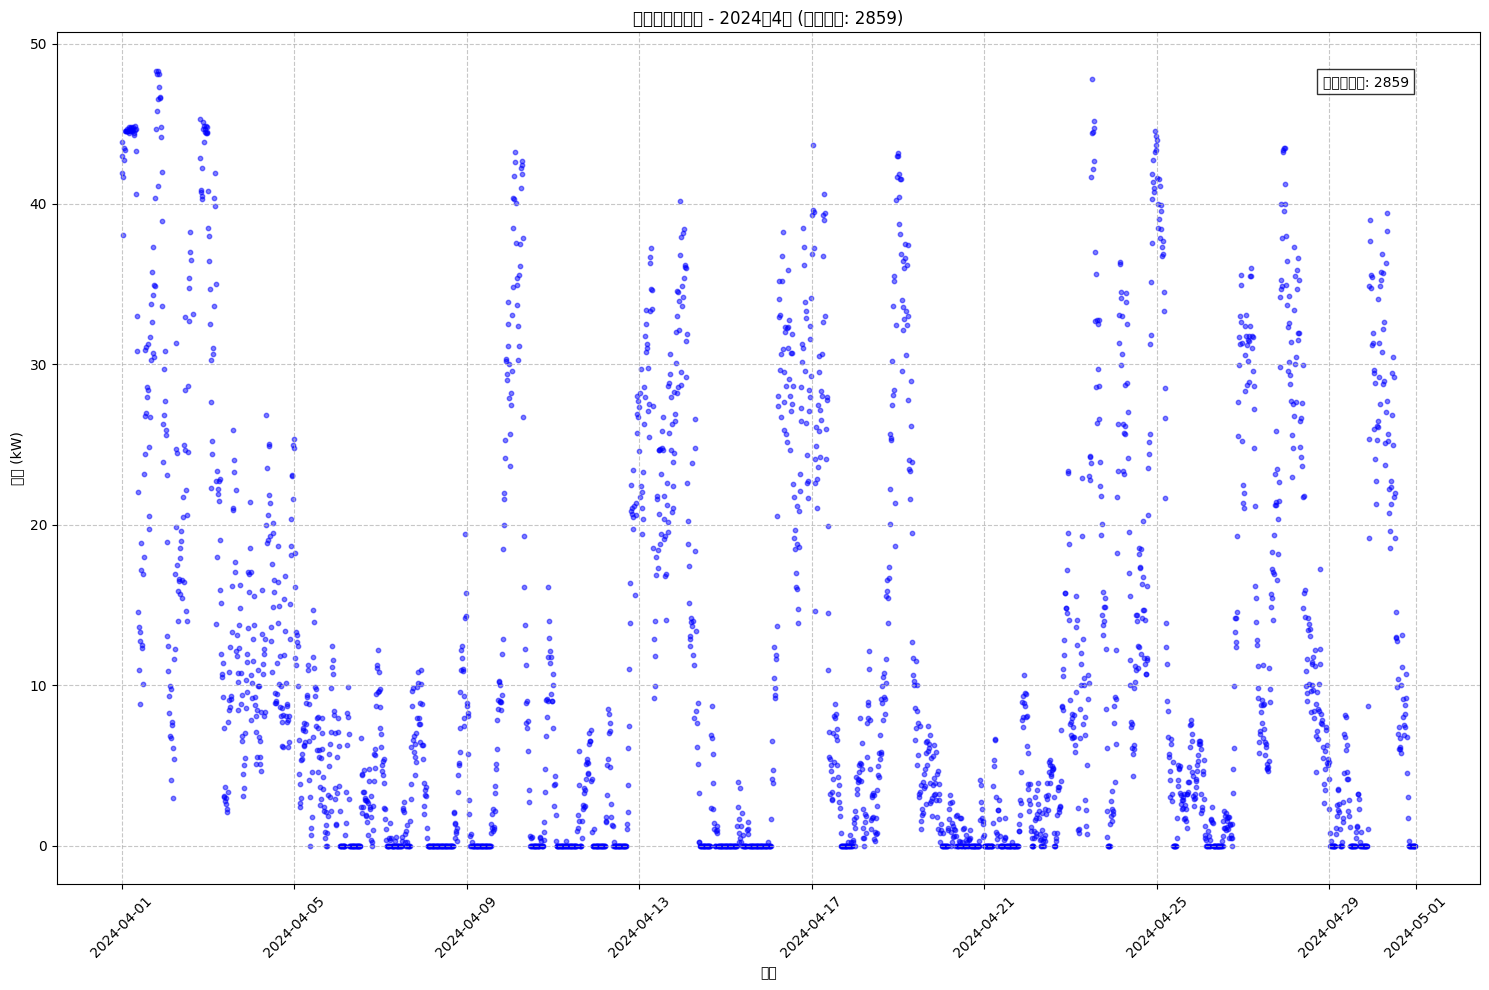

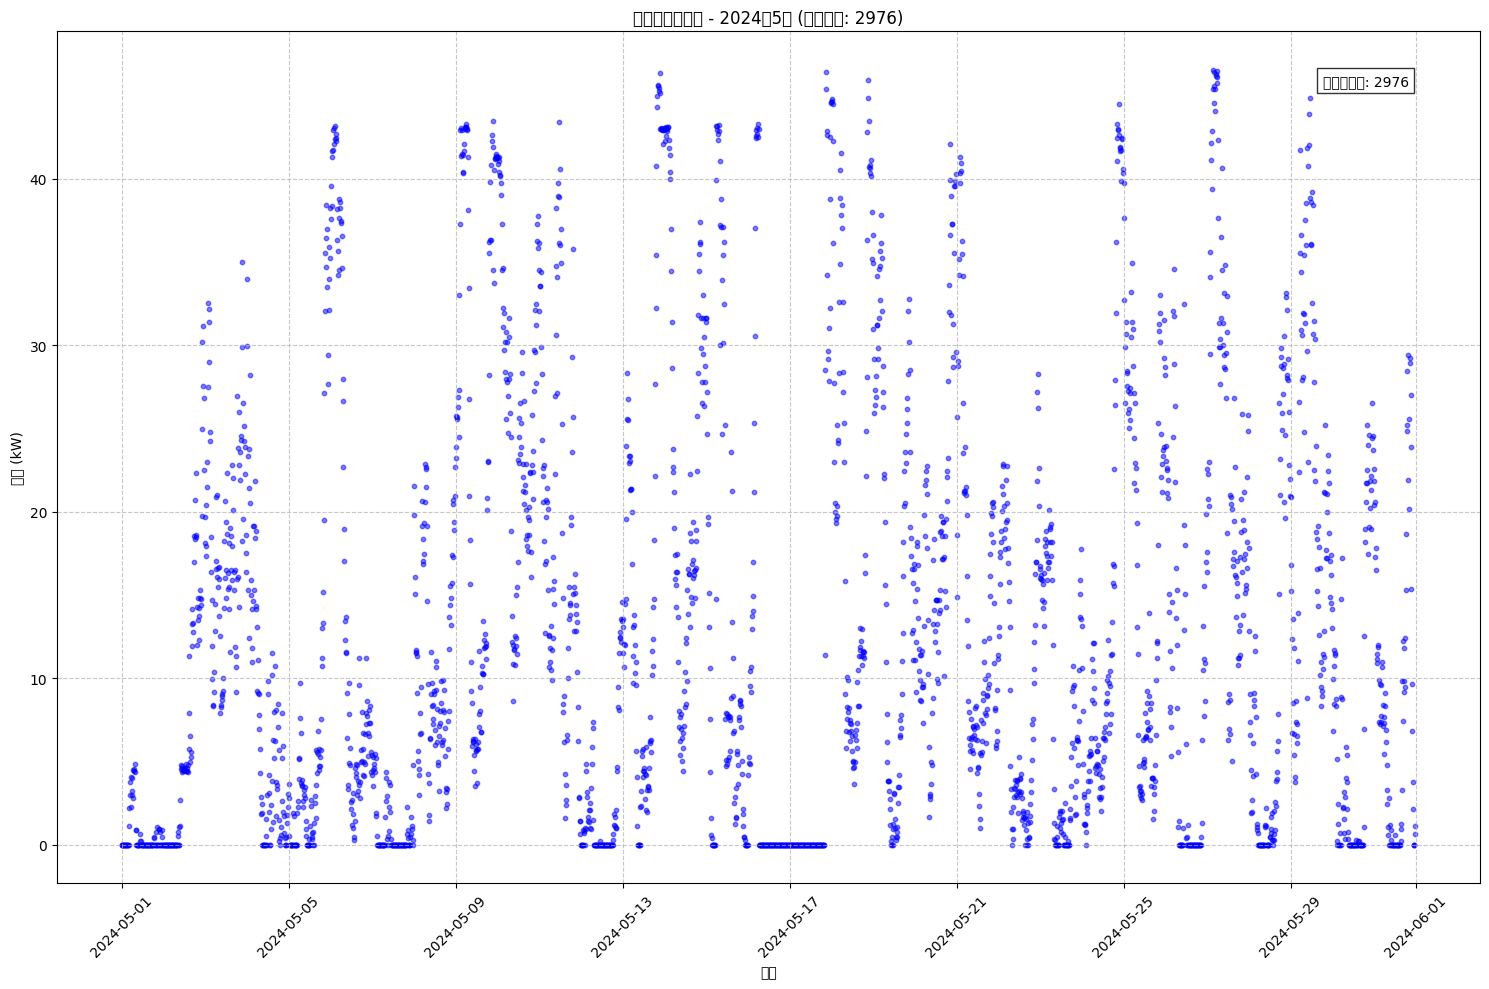

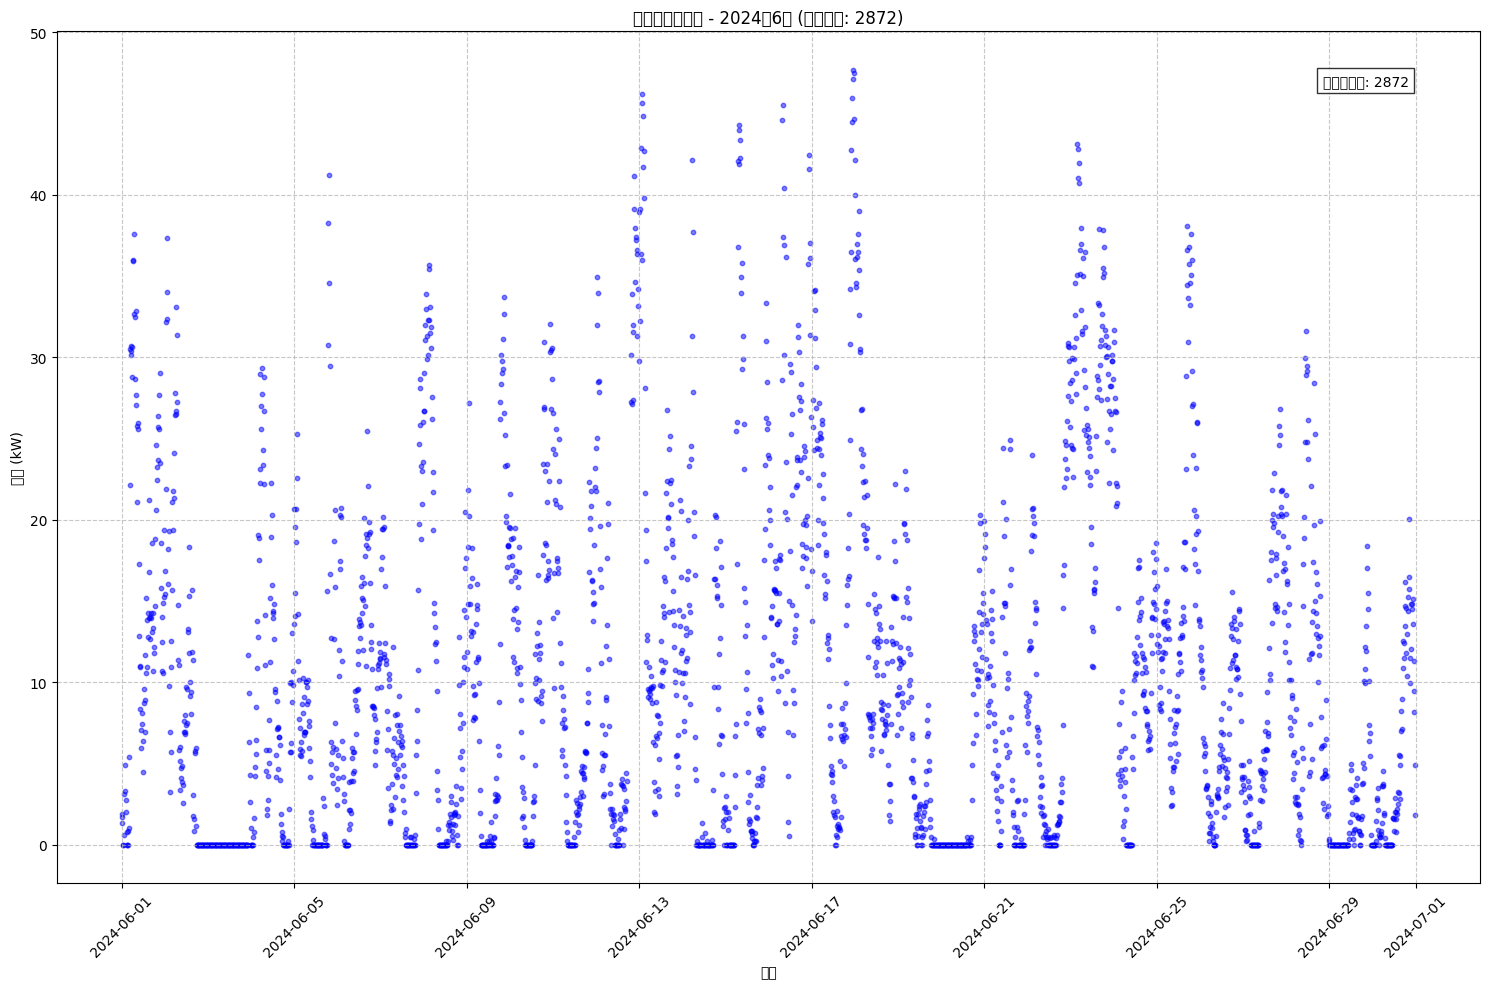

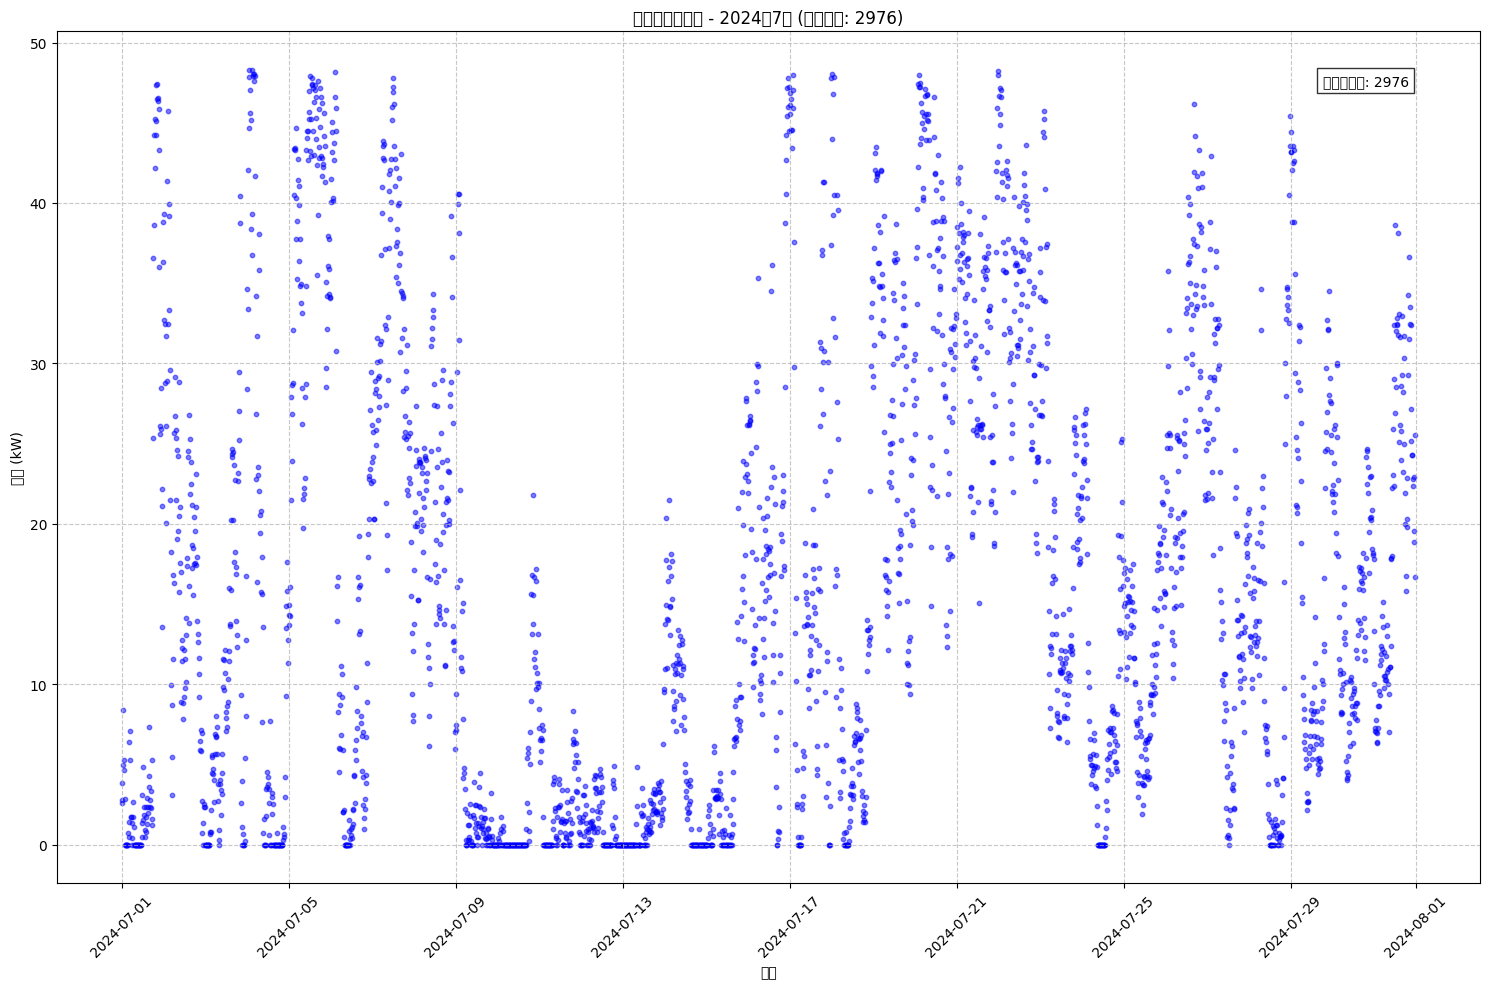

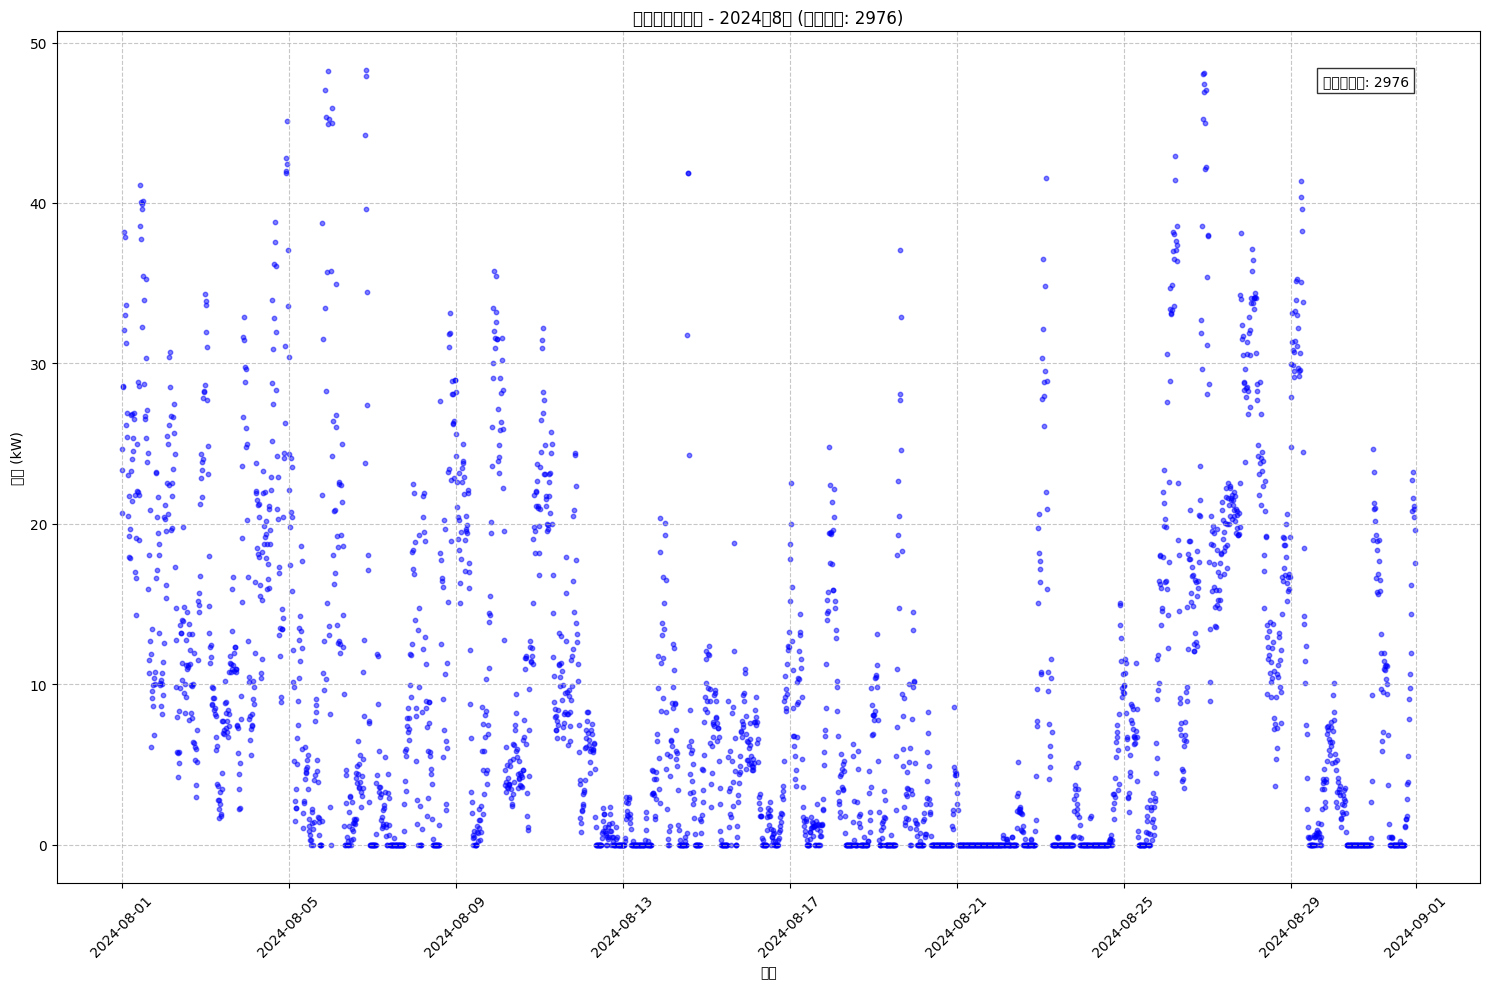

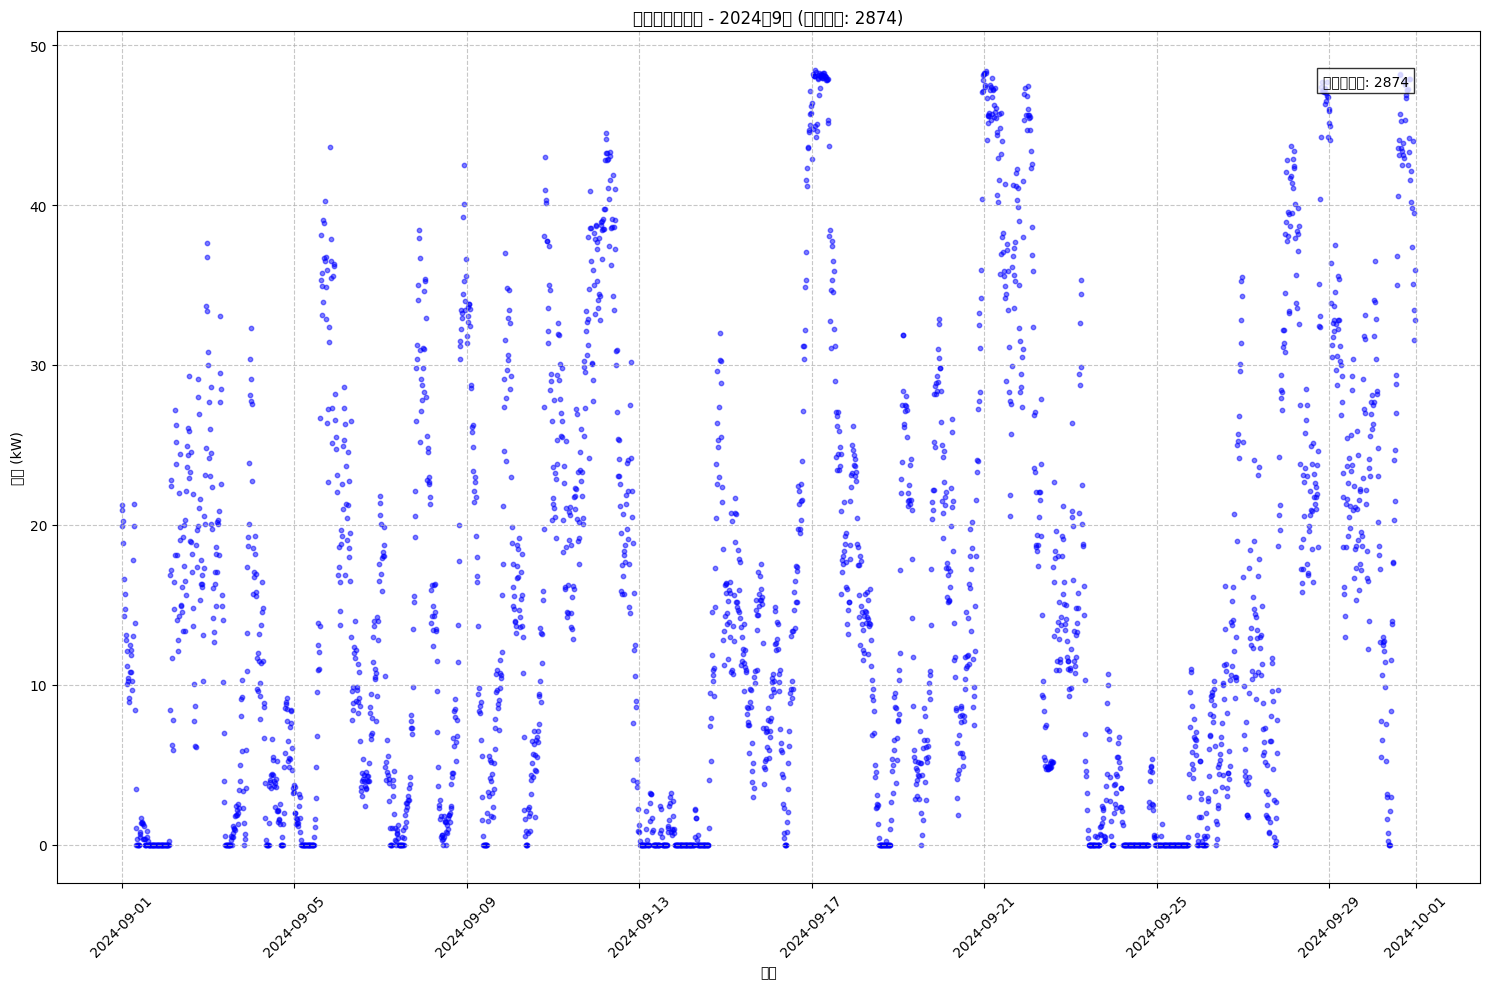

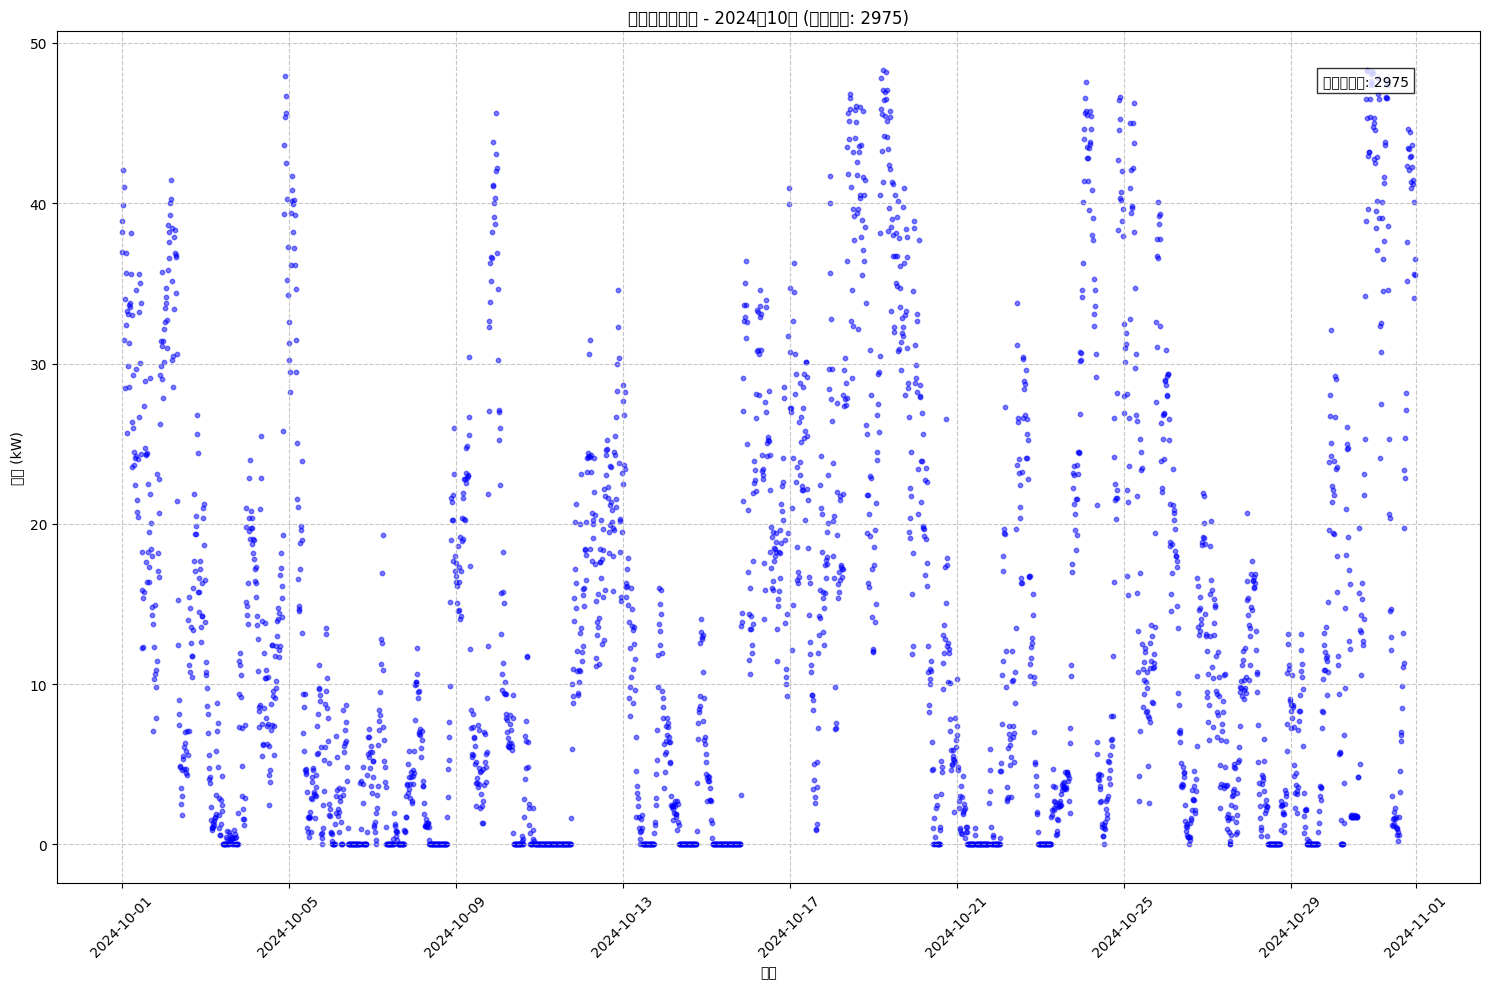

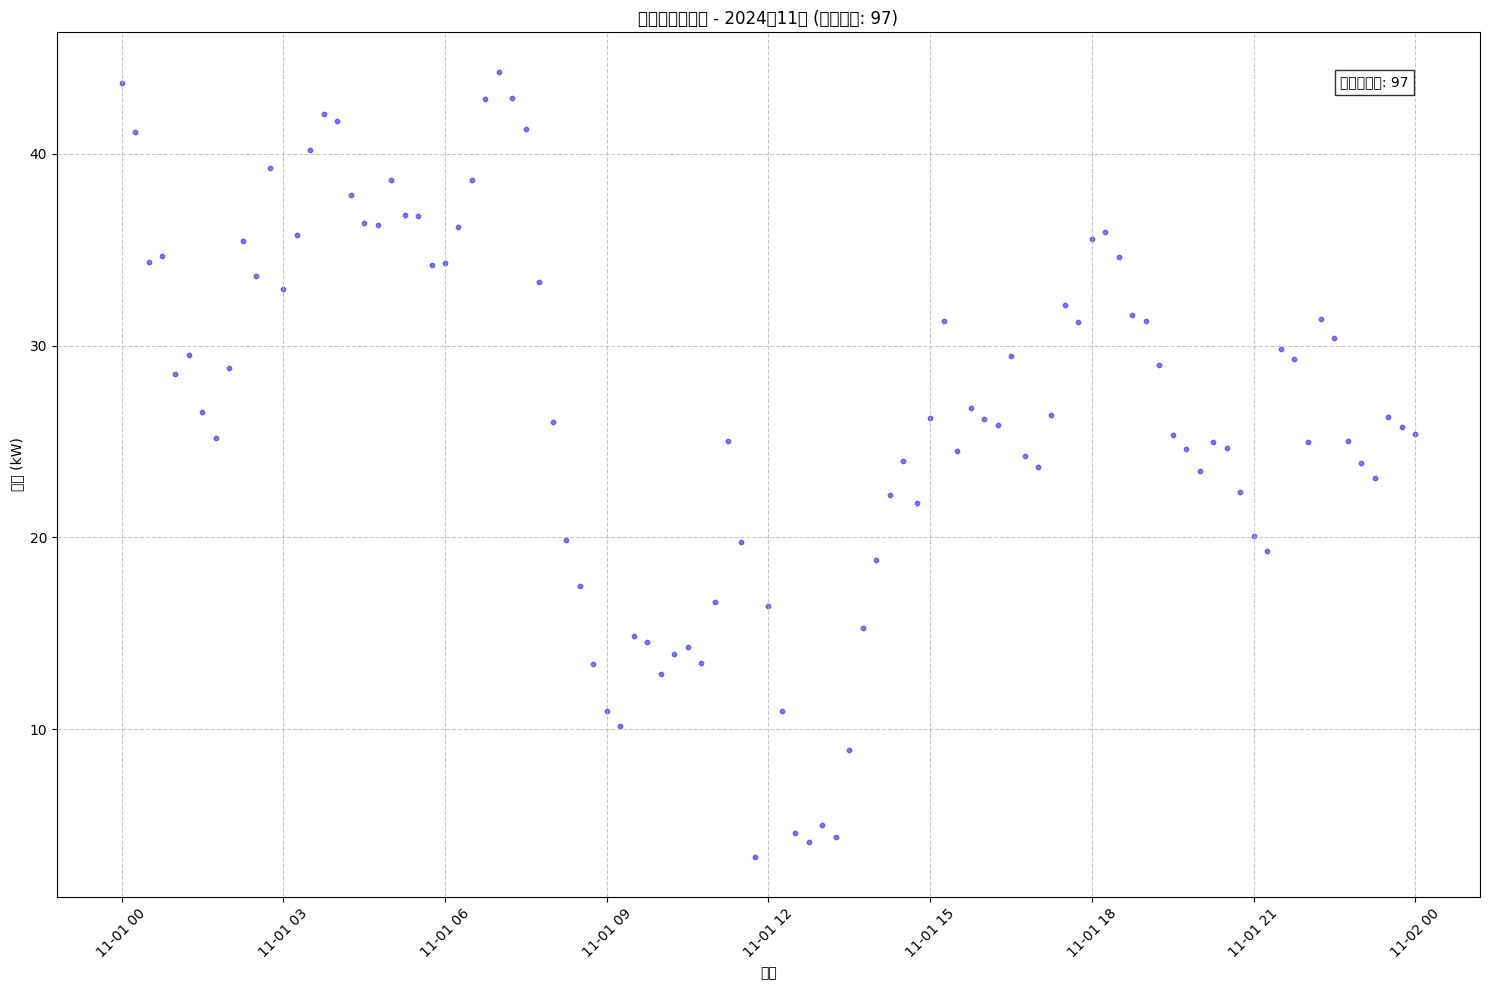

In [5]:
file_path = r'E:/Power_Pre_Model/actual_value/安徽.峡锐场发电功率实测值.txt'

# 读取数据（假设数据分隔符为空格）
df = pd.read_csv(
    file_path,
    header=0,
    low_memory=False,
    names=["time", "power"]  # 直接指定列名
)
df['time'] = pd.to_datetime((df['time']), errors='coerce')
df.set_index('time', inplace=True)

#按15分钟重采样
mask = (df.index.minute%15 ==0) & (df.index.second == 0)
df = df.loc[mask]

# 按年月分别绘制散点图
years = df.index.year.unique()
months = range(1, 13)  # 1-12月

for year in years:
    for month in months:
        data = df[(df.index.year == year) & (df.index.month == month)]
        if not data.empty:  # 只绘制有数据的月份
            # 计算该月数据点数量
            data_points = len(data)
            
            plt.figure(figsize=(15, 10))
            plt.scatter(data.index, data['power'], alpha=0.5, s=10, color='blue')
            
            plt.xlabel('时间')
            plt.ylabel('功率 (kW)')
            plt.title(f'鲁山场发电功率 - {year}年{month}月 (数据点数: {data_points})')
            plt.xticks(rotation=45)
            plt.grid(True, linestyle='--', alpha=0.7)
            
            # 在图表右上角添加数据点信息
            plt.text(0.95, 0.95, f'数据点数量: {data_points}', 
                    transform=plt.gca().transAxes,
                    verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.8))
            
            plt.tight_layout()

            # plt.show()
            
            # 打印每月数据点数量
            print(f'{year}年{month}月的数据点数量: {data_points}')



### 读取实测气象数据

In [6]:
file_path = r'E:\Power_Pre_Model\actual_value\AH_XR_WP_actual.txt'

# 读取数据（假设数据分隔符为空格）
df_xr = pd.read_csv(
    file_path,
    sep=',',
    encoding='utf-8',
    low_memory=False,
    header=0,
    usecols=[0,1,2],
    names=['time','height','wind_speed']
)
df_xr['time'] = pd.to_datetime((df_xr['time']), errors='coerce')
df_xr.set_index('time', inplace=True)

# 获取所有唯一的高度值
heights = df_xr['height'].unique()

# 创建一个新的DataFrame来存储合并后的数据
df_xr_merge = pd.DataFrame(index=df_xr.index.unique())

# 对每个高度，提取相应的风速数据并添加到新DataFrame中
for height in heights:
    # 筛选特定高度的数据
    height_data = df_xr[df_xr['height'] == height].copy()
    
    # 添加带有高度后缀的列
    df_xr_merge[f'wind_speed_{int(height)}m_act'] = height_data['wind_speed']

# 按时间排序
df_xr_merge.sort_index(inplace=True)

#按15分钟重采样
mask = (df_xr_merge.index.minute%15 ==0) & (df_xr_merge.index.second == 0)
df_xr_merge = df_xr_merge.loc[mask]

df_xr_merge


wind_speed_10m_act  wind_speed_30m_act  \
time                                                          
2023-09-01 00:00:00               0.380                0.46   
2023-09-01 00:15:00               0.220                0.40   
2023-09-01 00:30:00               0.360                0.28   
2023-09-01 00:45:00               0.917                0.60   
2023-09-01 01:00:00               0.280                0.74   
...                                 ...                 ...   
2024-11-01 23:00:00               1.375                1.60   
2024-11-01 23:15:00               1.725                1.40   
2024-11-01 23:30:00               2.100                2.00   
2024-11-01 23:45:00               1.533                1.90   
2024-11-02 00:00:00               1.525                1.60   

                     wind_speed_50m_act  wind_speed_70m_act  \
time                                                          
2023-09-01 00:00:00                 0.1                 0.3   
2023-09-01 00:15:00                 0.1                 0.2   
2023-09-01 00:30:00                 0.1                 0.0   
2023-09-01 00:45:00                 0.3                 0.2   
2023-09-01 01:00:00                 0.2                 0.3   
...                                 ...                 ...   
2024-11-01 23:00:00                 0.3                 1.0   
2024-11-01 23:15:00                 0.2                 1.0   
2024-11-01 23:30:00                 0.2                 1.6   
2024-11-01 23:45:00                 0.4                 1.2   
2024-11-02 00:00:00                 0.2                 1.1   

                     wind_speed_140m_act  
time                                      
2023-09-01 00:00:00                 0.76  
2023-09-01 00:15:00                 0.60  
2023-09-01 00:30:00                 0.62  
2023-09-01 00:45:00                 1.10  
2023-09-01 01:00:00                 1.04  
...                                  ...  
2024-11-01 23:00:00                 2.30  
2024-11-01 23:15:00                 1.80  
2024-11-01 23:30:00                 2.40  
2024-11-01 23:45:00                 2.50  
2024-11-02 00:00:00                 2.30  

[40360 rows x 5 columns]

### 读取XR预测功率数据

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13868\3867849471.py:48: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13868\3867849471.py:48: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13868\3867849471.py:48: UserWarning: Glyph 21151 (\N{CJK UNIFIED IDEOGRAPH-529F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13868\3867849471.py:48: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_13868\3867849471.py:48: UserWarning: Glyph 40065 (\N{CJK UNIFIED IDEOGRAPH-9C81}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_138

2023年9月的数据点数量: 2591
2023年10月的数据点数量: 2976
2023年11月的数据点数量: 2880
2023年12月的数据点数量: 2976
2024年1月的数据点数量: 2976
2024年2月的数据点数量: 2784
2024年3月的数据点数量: 2976
2024年4月的数据点数量: 2880
2024年5月的数据点数量: 2976
2024年6月的数据点数量: 2880
2024年7月的数据点数量: 2976
2024年8月的数据点数量: 2976
2024年9月的数据点数量: 2880
2024年10月的数据点数量: 2976
2024年11月的数据点数量: 97


e:\Power_Pre_Model\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21151 (\N{CJK UNIFIED IDEOGRAPH-529F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Power_Pre_Model\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Power_Pre_Model\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40065 (\N{CJK UNIFIED IDEOGRAPH-9C81}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Power_Pre_Model\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Power_Pre_Model\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22330 (\N{CJK UNIFIED IDEOGRAPH-573A}) missing from font(s) DejaVu Sans.
  

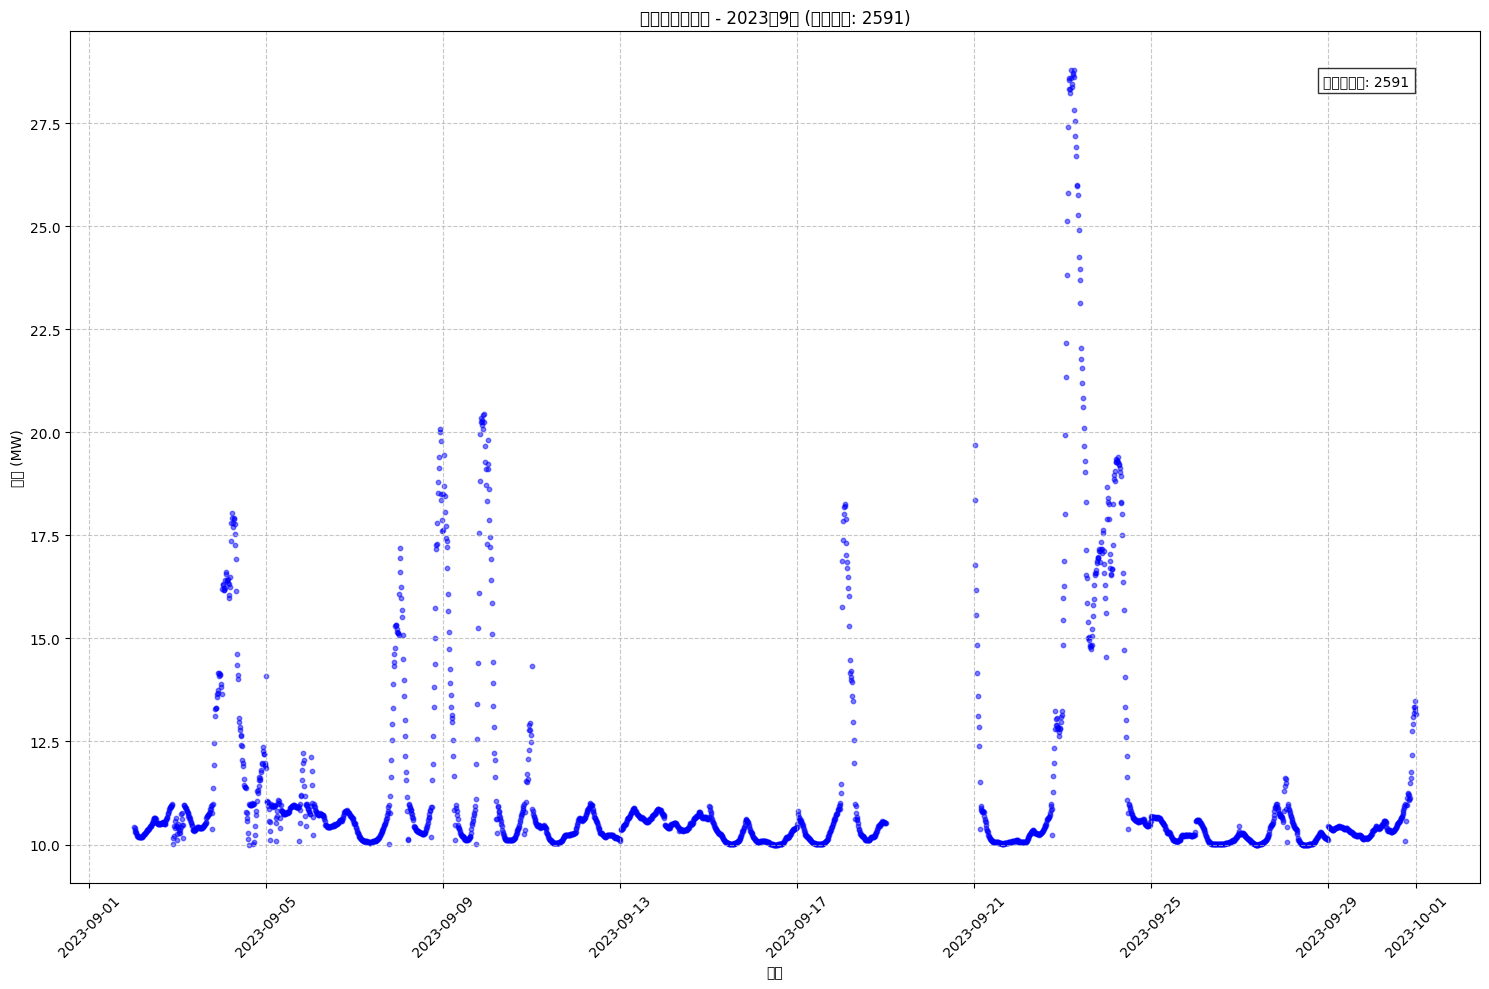

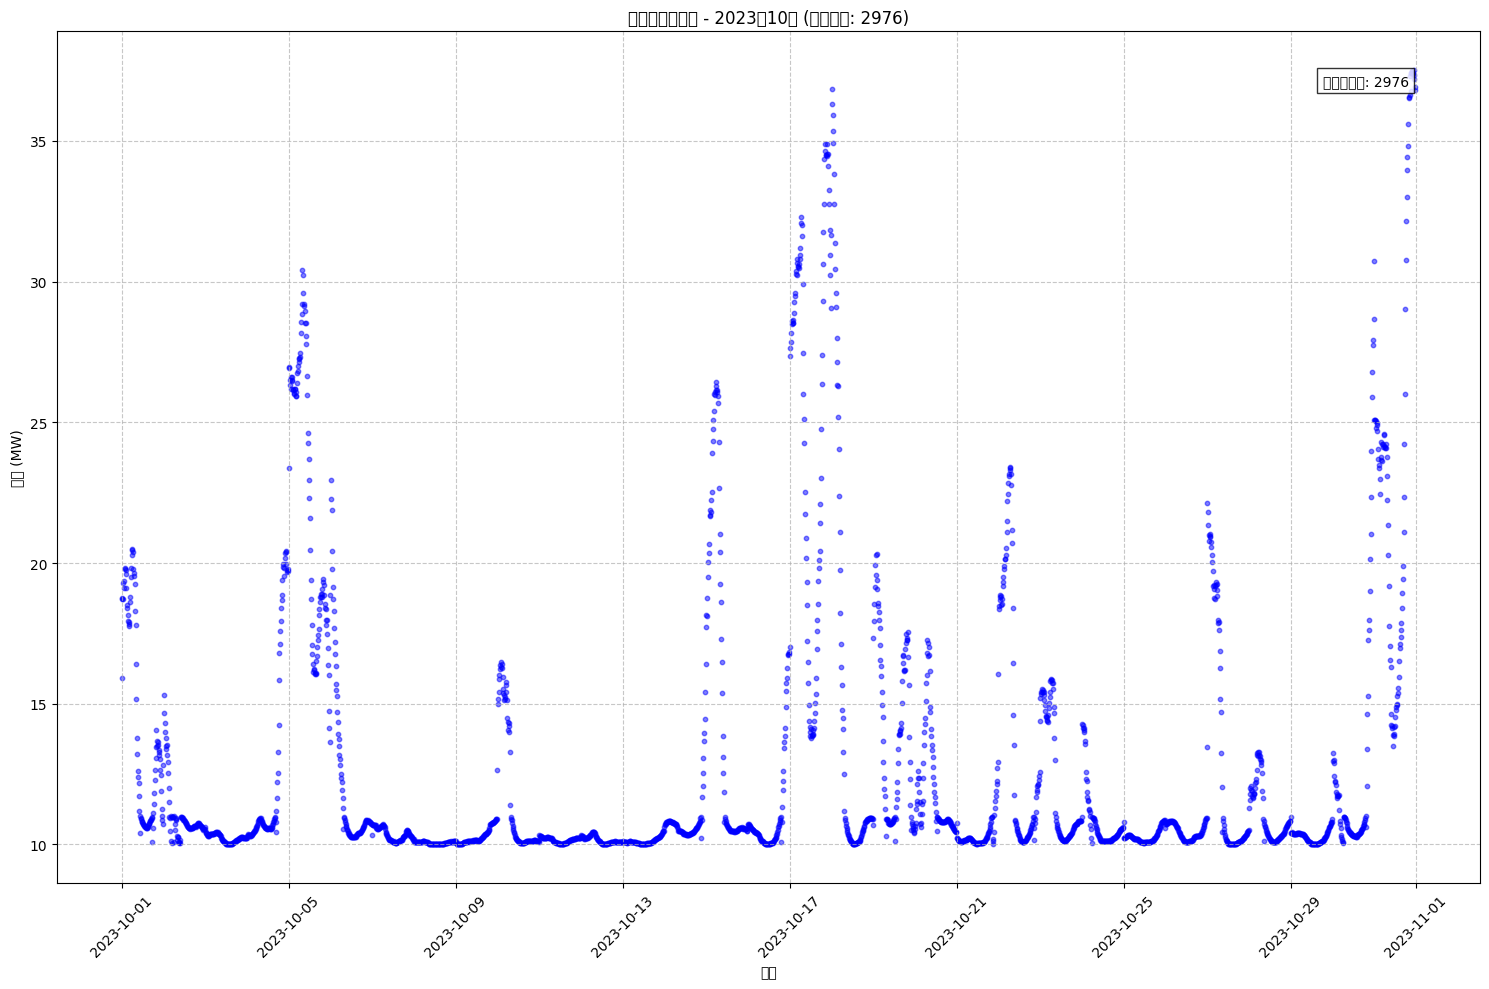

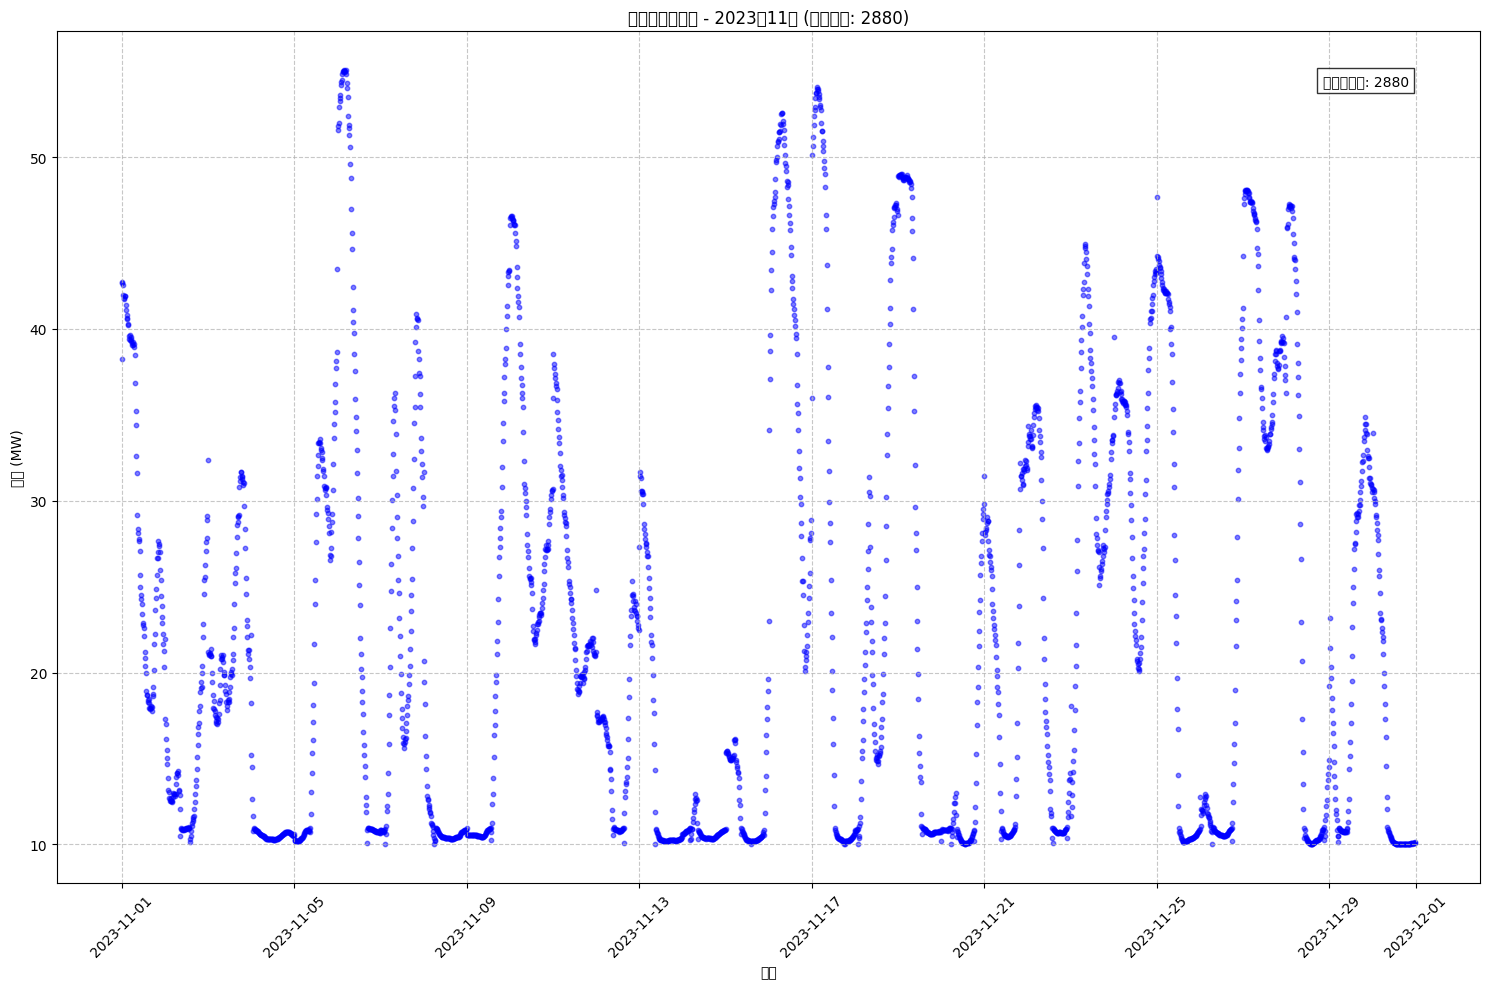

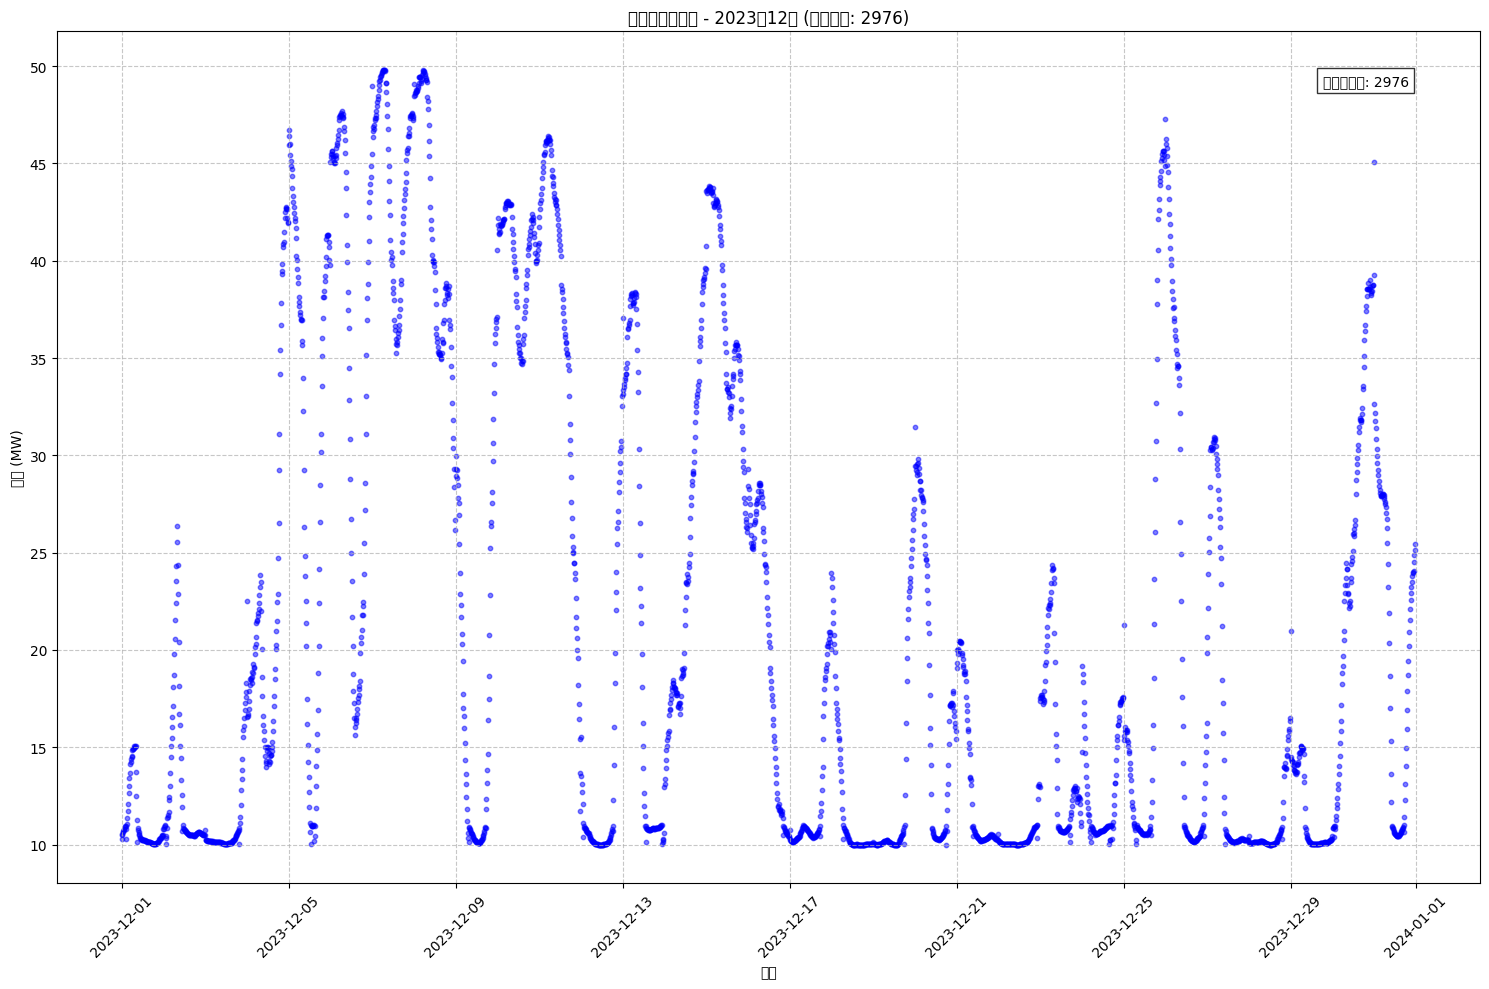

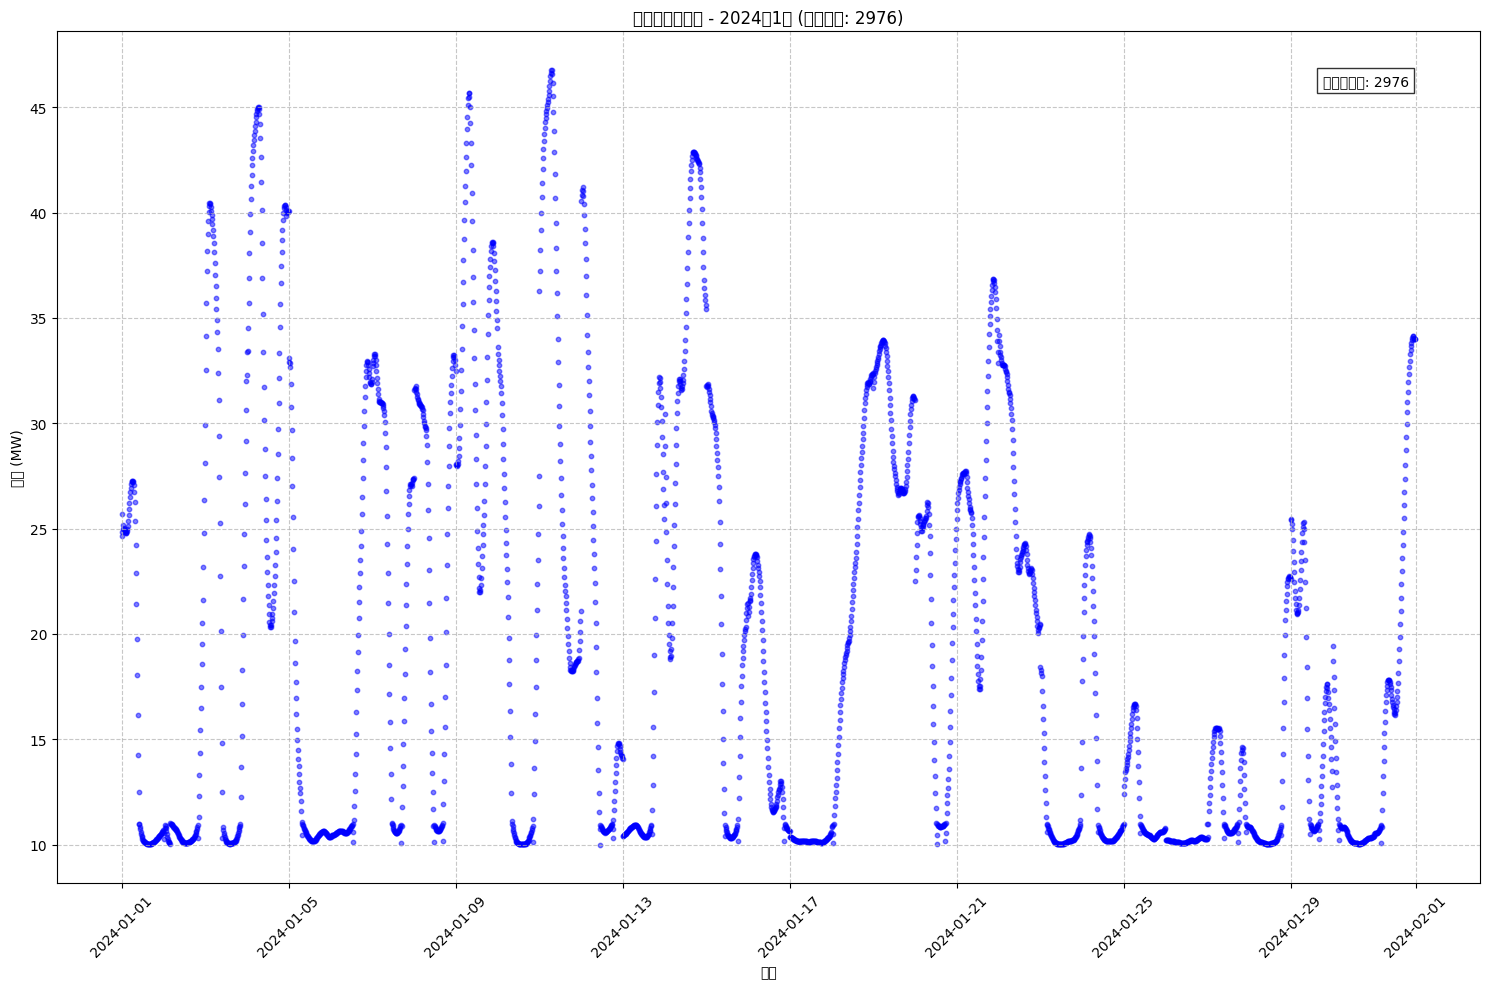

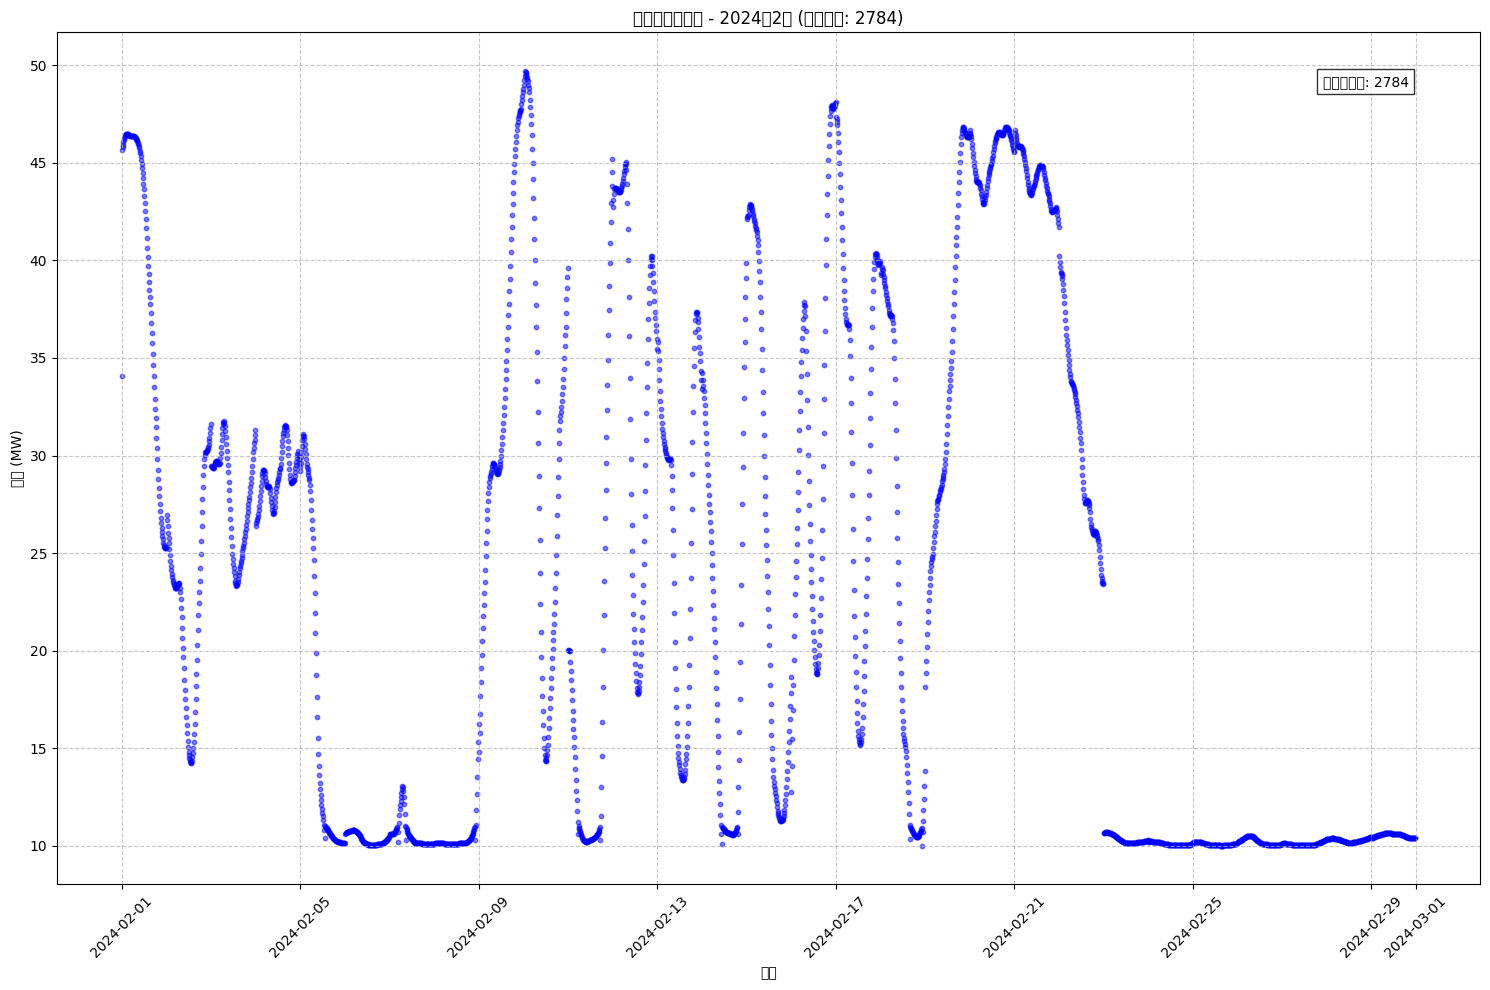

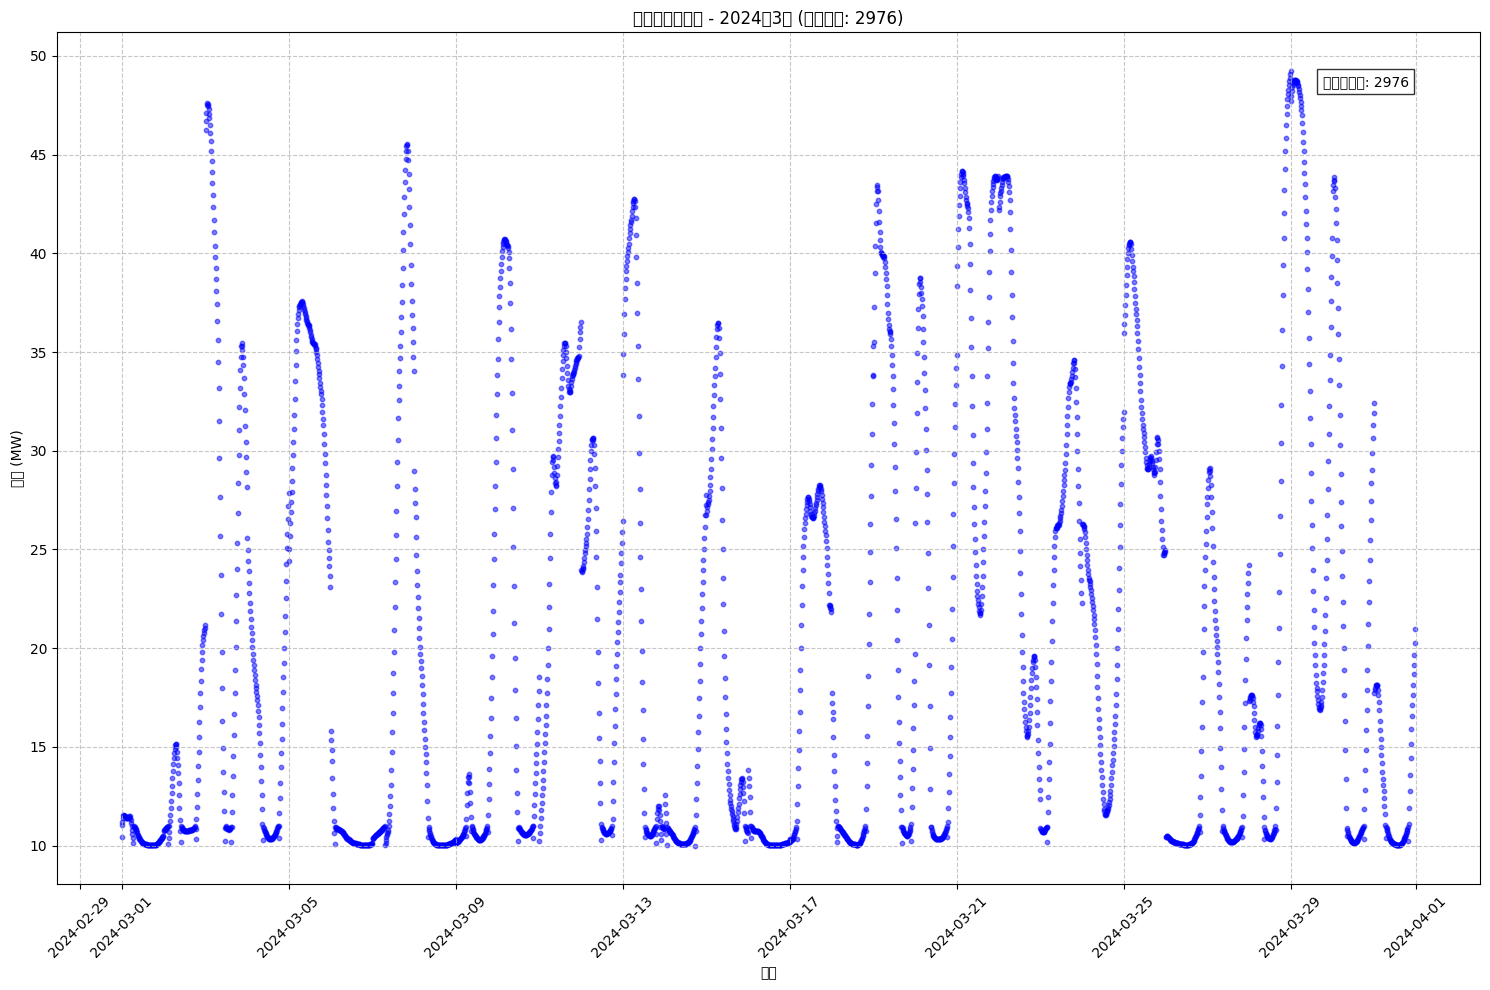

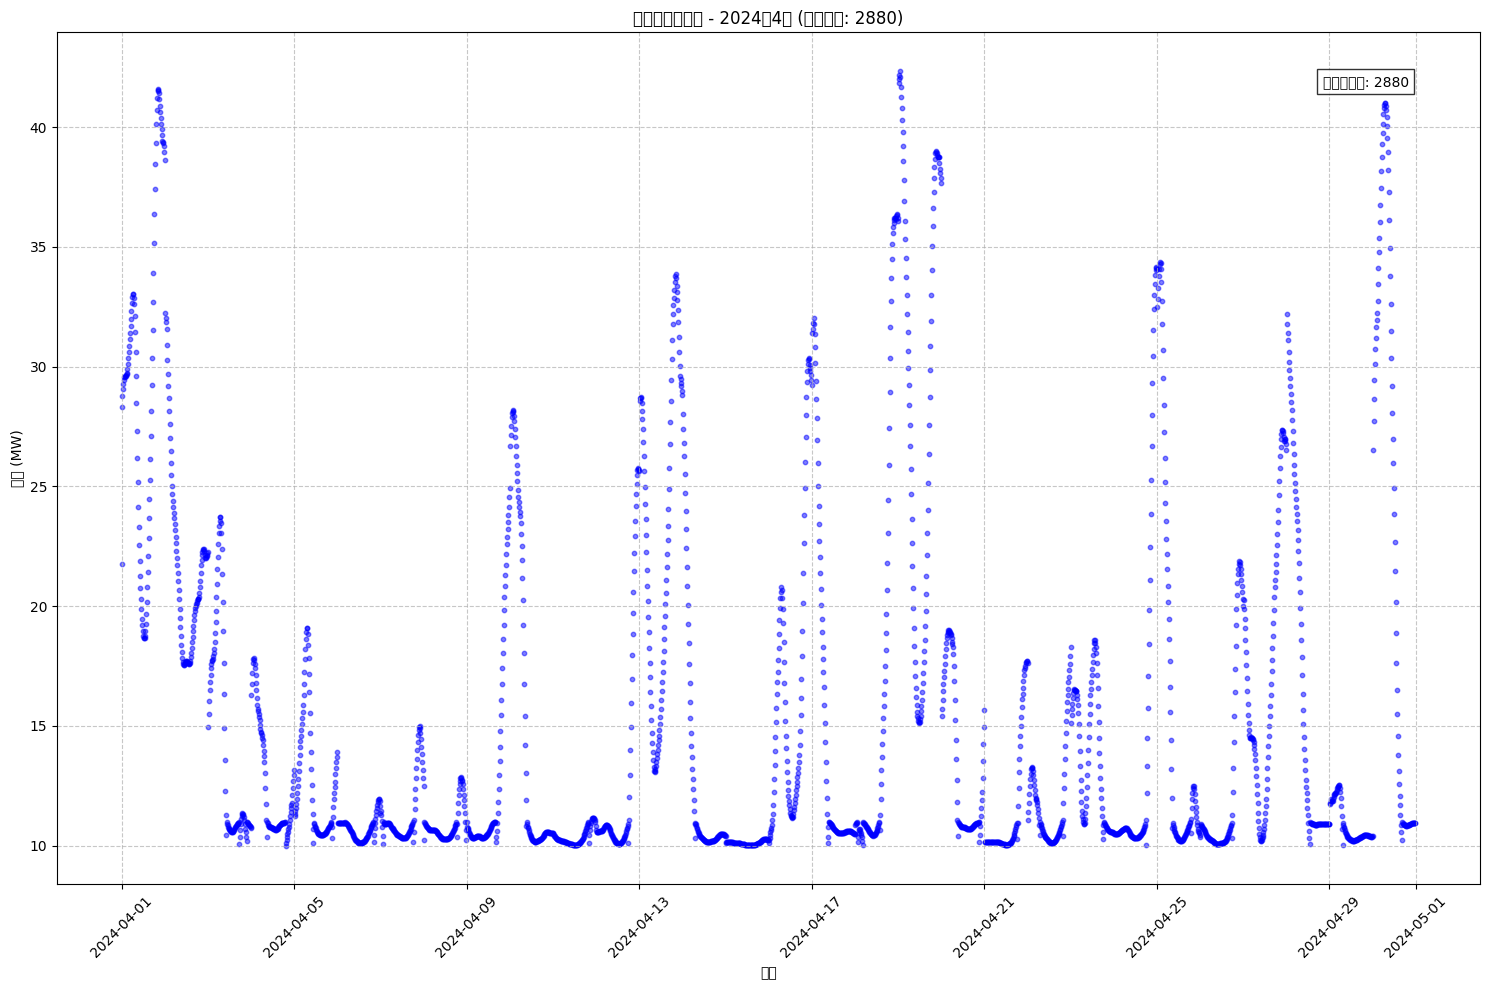

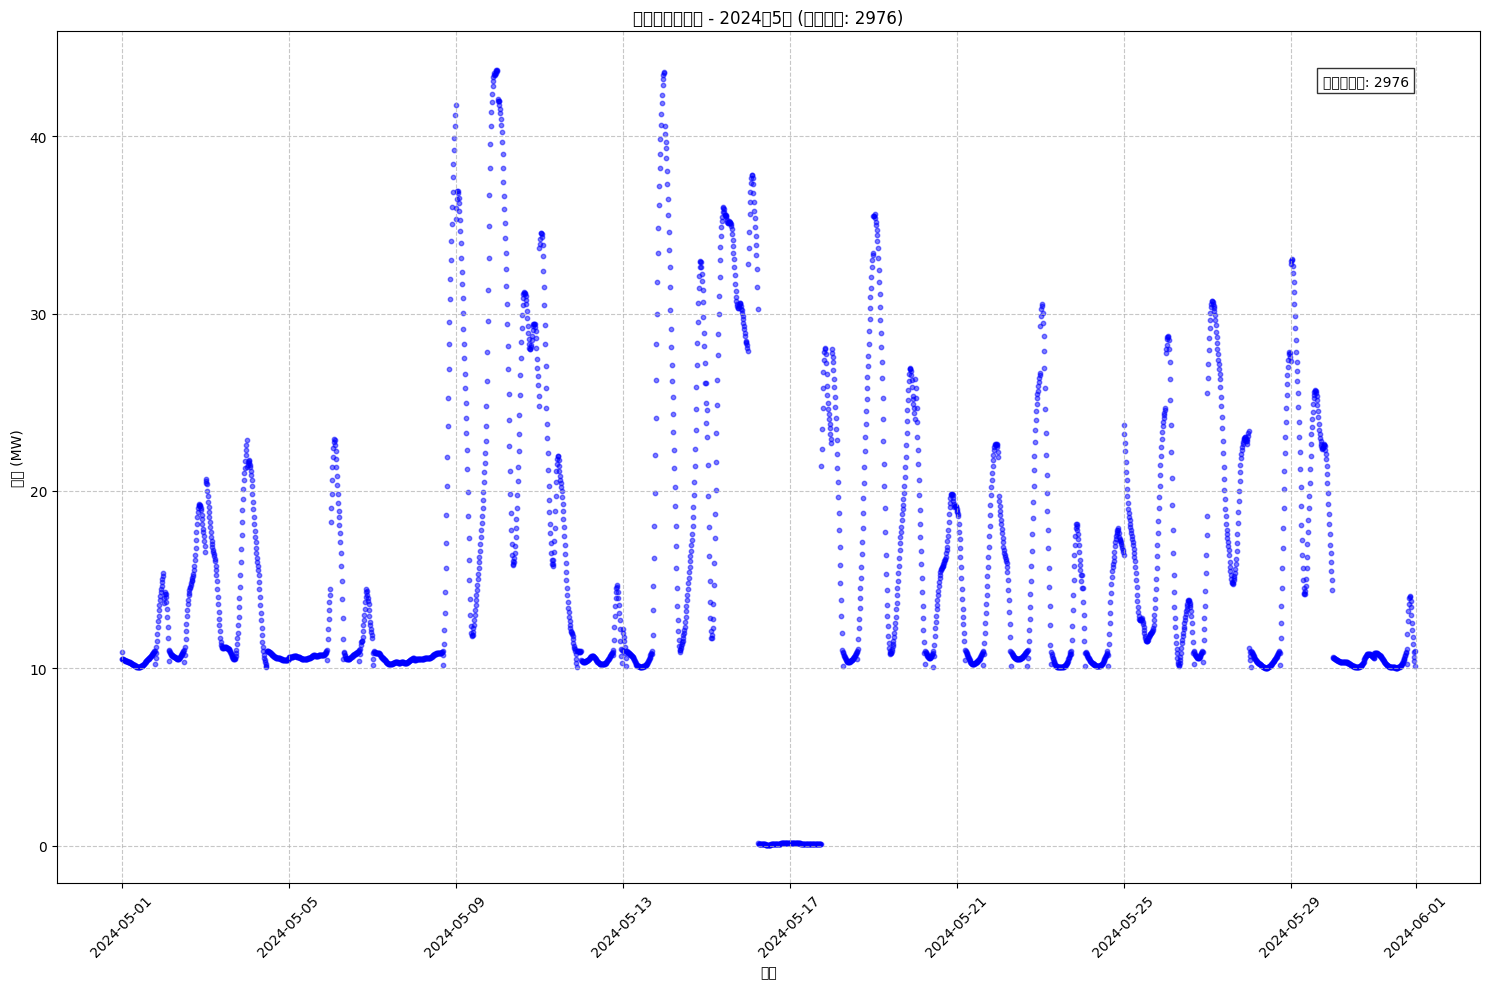

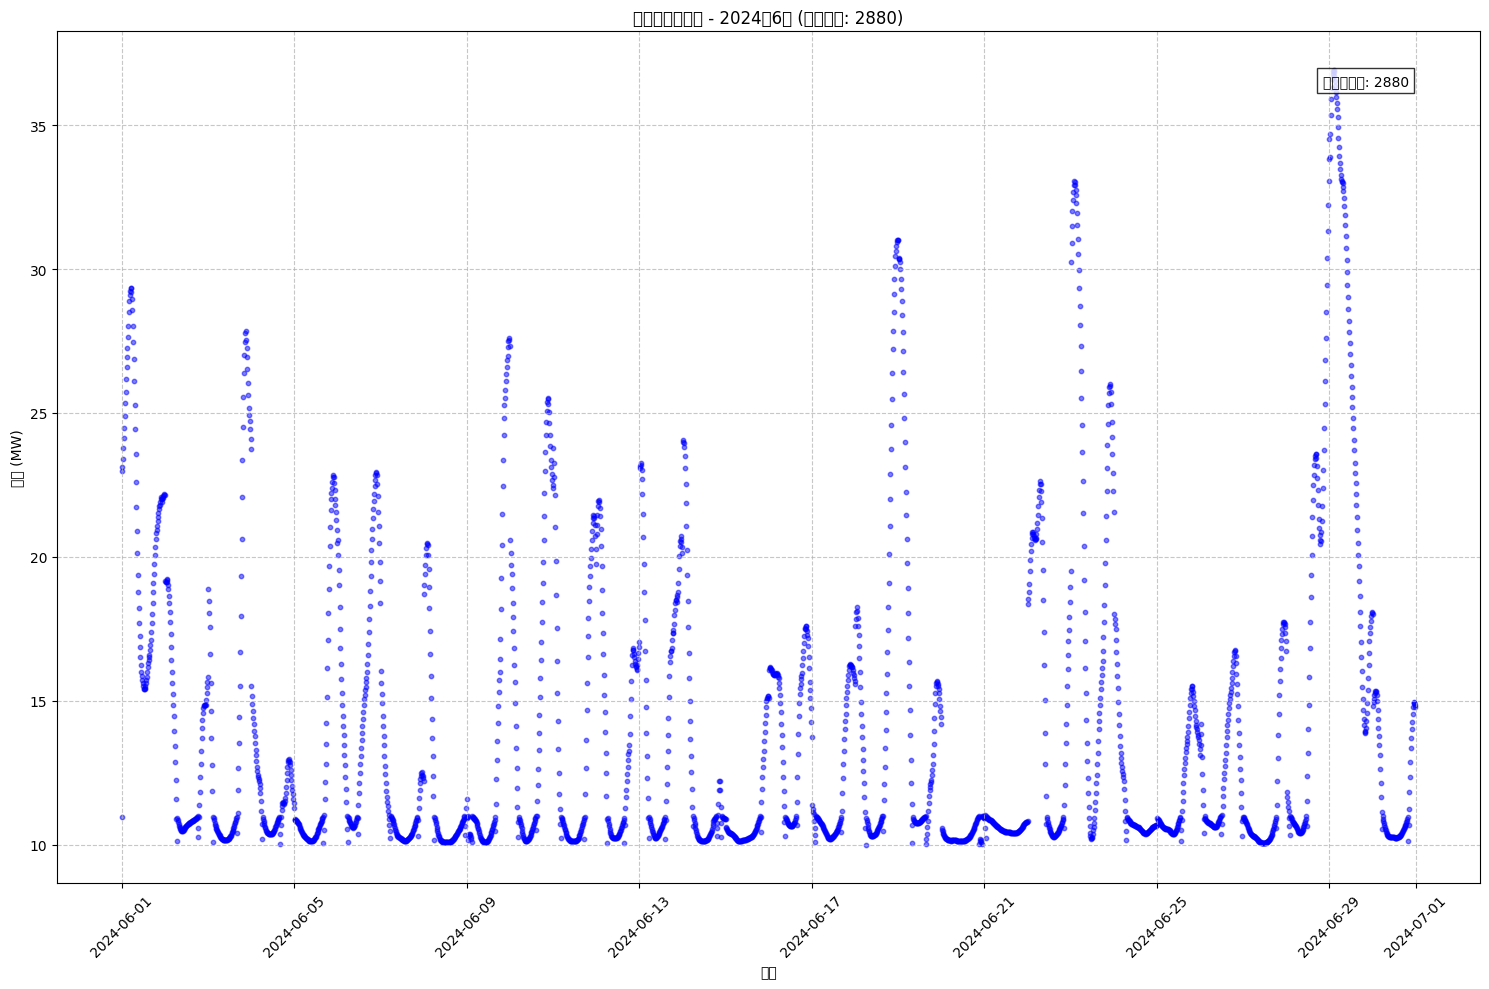

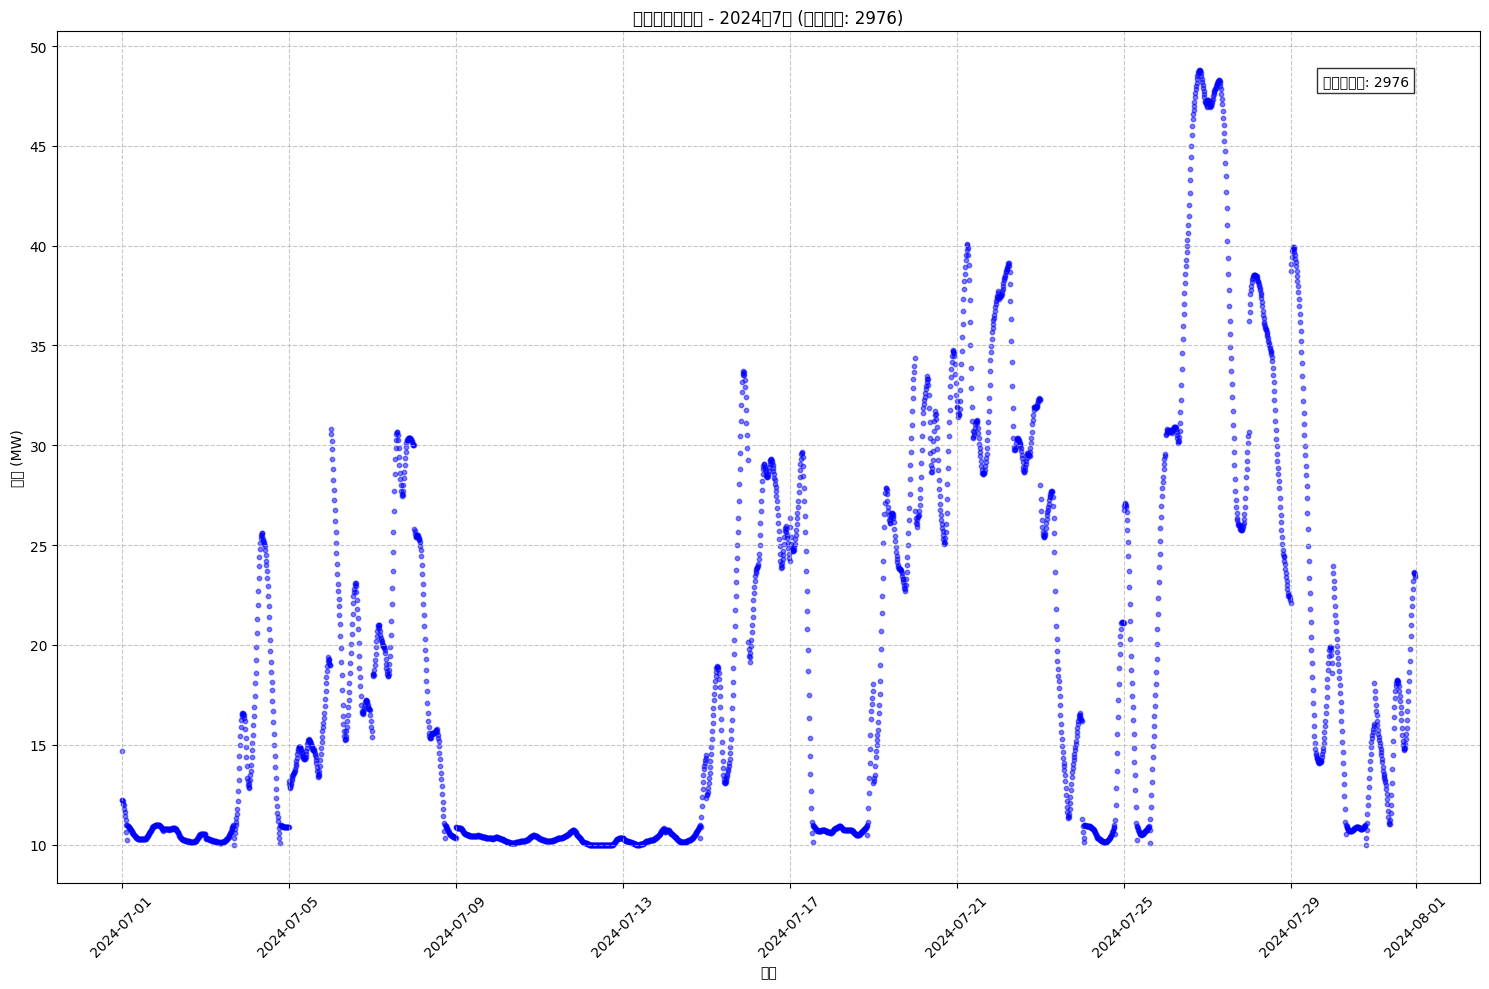

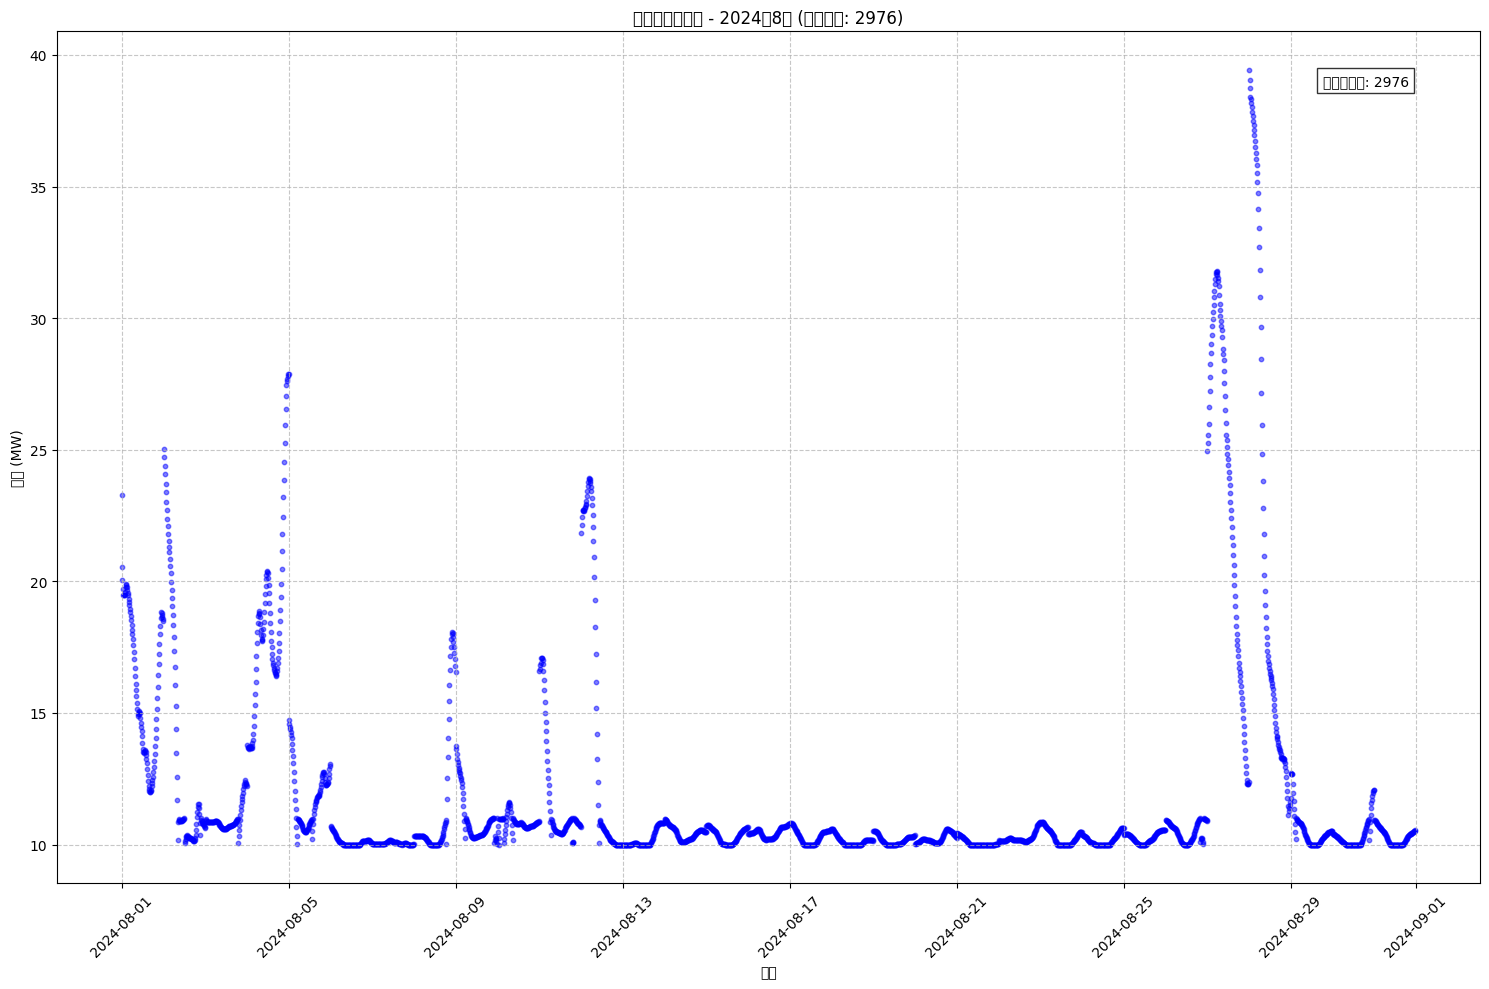

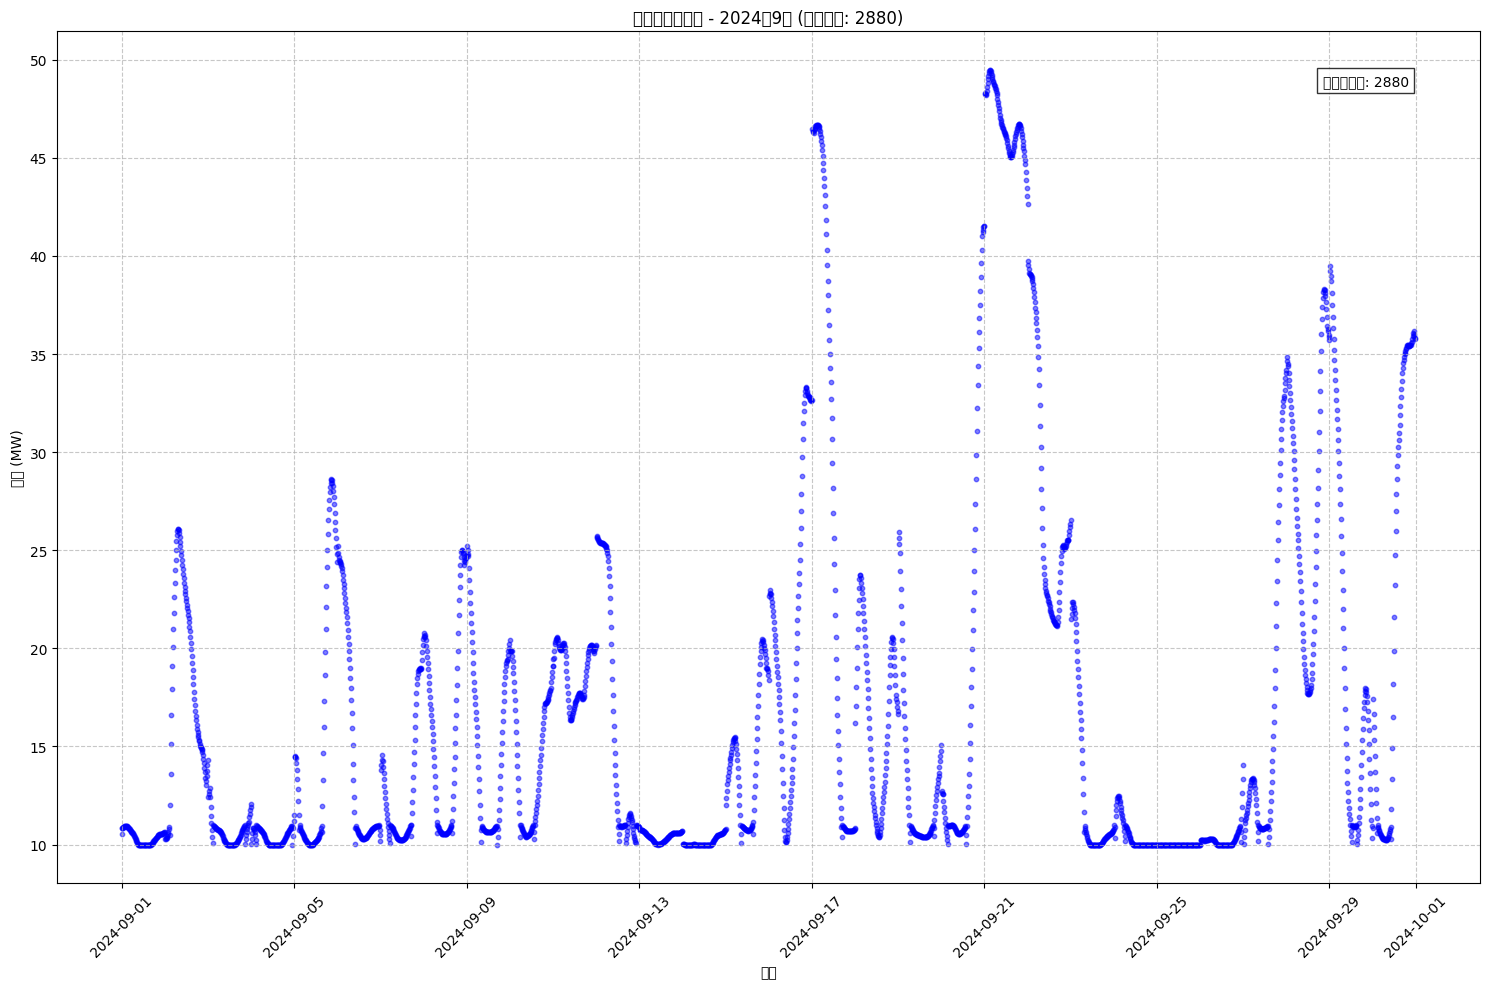

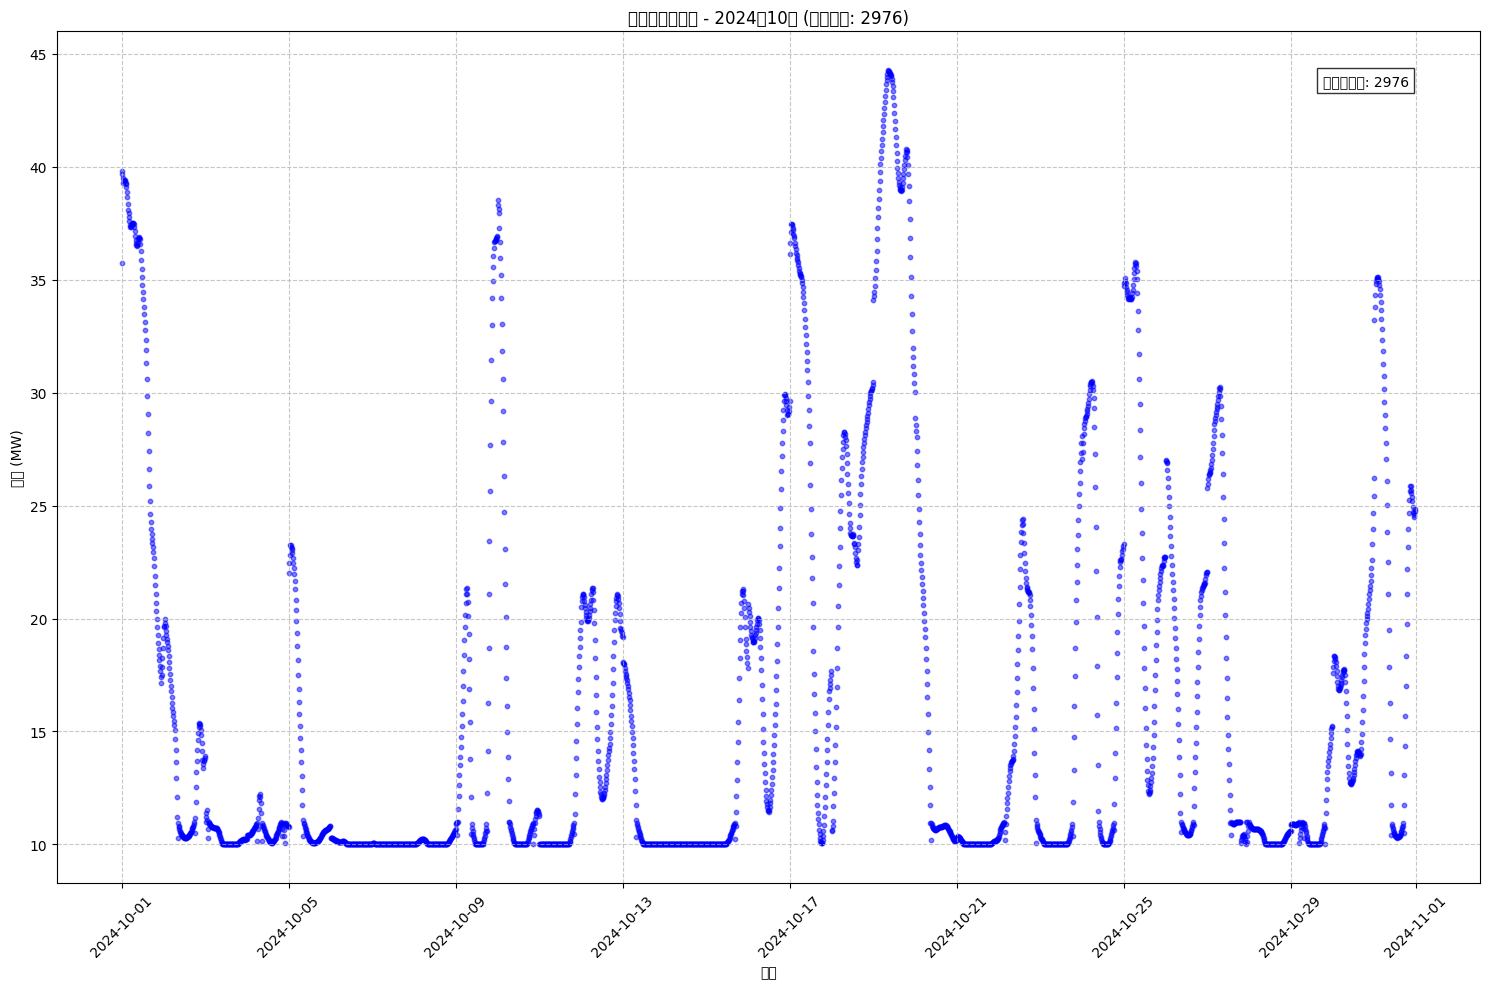

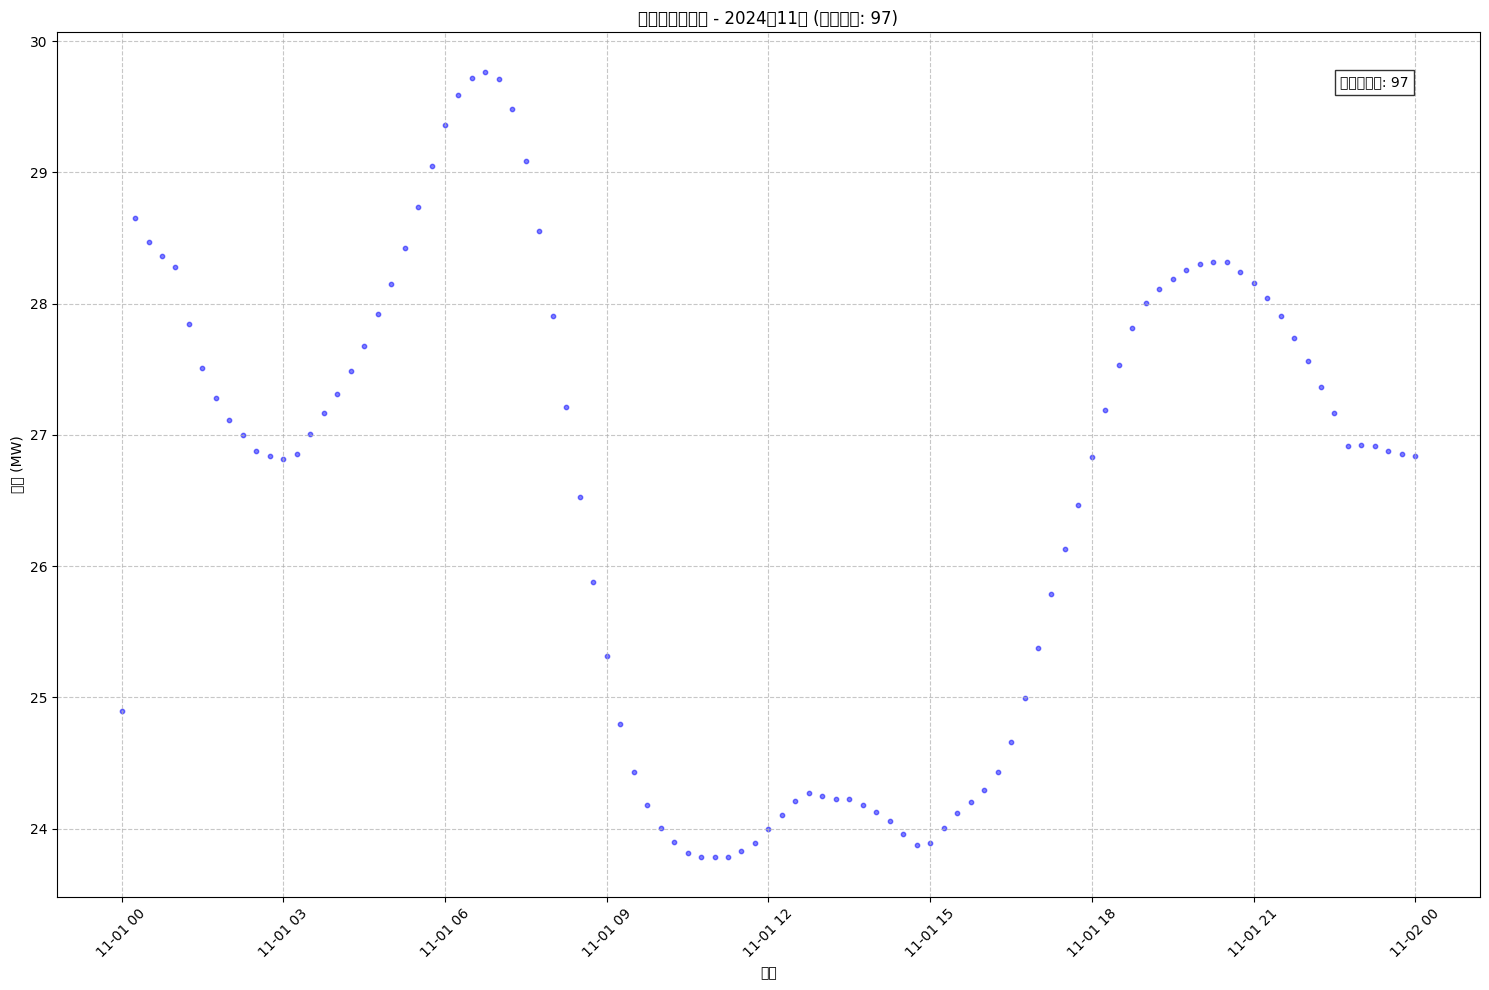

In [7]:
file_path = r'E:\Power_Pre_Model\actual_value\安徽.峡锐场短期功率预测.txt'

# 读取数据（假设数据分隔符为空格）
df_pre_xr = pd.read_csv(
    file_path,
    header=0,
    low_memory=False,
    usecols=[1,2],
    names=["time", "power_xr"]  # 直接指定列名
)
# 转换时间列并删除重复时间值
df_pre_xr['time'] = pd.to_datetime(df_pre_xr['time'], errors='coerce')
df_pre_xr = df_pre_xr.drop_duplicates(subset=['time'], keep='first')
df_pre_xr.set_index('time', inplace=True)


#按15分钟重采样
mask = (df_pre_xr.index.minute%15 ==0) & (df_pre_xr.index.second == 0)
df_pre_xr = df_pre_xr.loc[mask]
df_pre_xr
# 按年月分别绘制散点图
years = df_pre_xr.index.year.unique()
months = range(1, 13)  # 1-12月

for year in years:
    for month in months:
        data = df_pre_xr[(df_pre_xr.index.year == year) & (df_pre_xr.index.month == month)]
        if not data.empty:  # 只绘制有数据的月份
            # 计算该月数据点数量
            data_points = len(data)
            
            plt.figure(figsize=(15, 10))
            plt.scatter(data.index, data['power_xr'], alpha=0.5, s=10, color='blue')
            
            plt.xlabel('时间')
            plt.ylabel('功率 (MW)')
            plt.title(f'鲁山场发电功率 - {year}年{month}月 (数据点数: {data_points})')
            plt.xticks(rotation=45)
            plt.grid(True, linestyle='--', alpha=0.7)
            
            # 在图表右上角添加数据点信息
            plt.text(0.95, 0.95, f'数据点数量: {data_points}', 
                    transform=plt.gca().transAxes,
                    verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.8))
            
            plt.tight_layout()
            save_dir = 'power_pre'
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f'峡锐场发电功率_{year}年{month}月散点图.png'), dpi=300, bbox_inches='tight')
            # plt.show()
            
            # 打印每月数据点数量
            print(f'{year}年{month}月的数据点数量: {data_points}')


## 合并数据集

In [11]:
from functools import reduce
# 使用reduce和merge函数优化多个数据框的合并操作
dfs = [df, df_xr_merge,merged_data,df_pre_xr]
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['time'], how='inner'), dfs)
merged_df.columns

Index(['time', 'power', 'wind_speed_10m_act', 'wind_speed_30m_act',
       'wind_speed_50m_act', 'wind_speed_70m_act', 'wind_speed_140m_act',
       'wind_speed_10m', 'wind_direction_10m', 'temperature_10m',
       'humidity_10m', 'pressure_10m', 'wind_speed_30m', 'wind_direction_30m',
       'temperature_30m', 'humidity_30m', 'pressure_30m', 'wind_speed_50m',
       'wind_direction_50m', 'temperature_50m', 'humidity_50m', 'pressure_50m',
       'wind_speed_70m', 'wind_direction_70m', 'temperature_70m',
       'humidity_70m', 'pressure_70m', 'wind_speed_90m', 'wind_direction_90m',
       'temperature_90m', 'humidity_90m', 'pressure_90m', 'wind_speed_110m',
       'wind_direction_110m', 'temperature_110m', 'humidity_110m',
       'pressure_110m', 'wind_speed_130m', 'wind_direction_130m',
       'temperature_130m', 'humidity_130m', 'pressure_130m', 'power_xr'],
      dtype='object')

In [12]:
merged_df['year_month'] = merged_df['time'].dt.to_period('M')
# 添加月份列
merged_df['month'] = merged_df['time'].dt.month
# 添加Time_code列(将时间转换为当天的分钟数)
merged_df['Time_code'] = merged_df['time'].dt.hour * 60 + merged_df['time'].dt.minute

# 过滤掉2024年5月的数据
merged_df = merged_df[~((merged_df['time'].dt.year == 2024) & (merged_df['time'].dt.month == 2))]

# 按年月分组
year_month_groups = merged_df.groupby('year_month')

# 遍历每组年月的数据
for year_month, monthly_data in year_month_groups:
    print(f"Year-Month: {year_month}")
    print(monthly_data)
print("\n")

train_sets = []
test_sets = []
for month, group in year_month_groups:
    last_ten_days = group.iloc[-960:].dropna()
    test_sets.append(last_ten_days)
    train_sets.append(group.iloc[:-960].dropna())

# 合并当前文件的所有月的最后五天数据
test_sets_A = pd.concat(test_sets)
train_sets_A= pd.concat(train_sets)
train_sets_A

Year-Month: 2023-09
                    time      power  wind_speed_10m_act  wind_speed_30m_act  \
0    2023-09-02 00:15:00   5.471585                0.50                0.30   
1    2023-09-02 00:30:00   4.957926                0.70                0.56   
2    2023-09-02 00:45:00   3.841276                0.32                0.40   
3    2023-09-02 01:00:00   3.439282                0.18                0.30   
4    2023-09-02 01:15:00   3.081954                0.42                0.10   
...                  ...        ...                 ...                 ...   
2227 2023-09-30 22:45:00  42.187038                2.82                1.86   
2228 2023-09-30 23:00:00  39.730408                1.54                2.00   
2229 2023-09-30 23:15:00  31.578861                1.00                1.48   
2230 2023-09-30 23:30:00  23.494316                0.50                0.60   
2231 2023-09-30 23:45:00  21.774675                0.48                0.46   

      wind_speed_50m_act  wind_

time     power  wind_speed_10m_act  wind_speed_30m_act  \
0     2023-09-02 00:15:00  5.471585               0.500               0.300   
1     2023-09-02 00:30:00  4.957926               0.700               0.560   
2     2023-09-02 00:45:00  3.841276               0.320               0.400   
3     2023-09-02 01:00:00  3.439282               0.180               0.300   
4     2023-09-02 01:15:00  3.081954               0.420               0.100   
...                   ...       ...                 ...                 ...   
38565 2024-10-21 22:45:00  0.000000               1.333               1.500   
38566 2024-10-21 23:00:00  0.000000               1.075               1.000   
38567 2024-10-21 23:15:00  0.000000               1.350               1.100   
38568 2024-10-21 23:30:00  0.000000               0.800               1.025   
38569 2024-10-21 23:45:00  0.000000               1.275               0.900   

       wind_speed_50m_act  wind_speed_70m_act  wind_speed_140m_act  \
0                    0.10                0.20                 0.60   
1                    0.10                0.30                 0.72   
2                    0.20                0.20                 0.80   
3                    0.00                0.24                 0.44   
4                    0.10                0.00                 0.30   
...                   ...                 ...                  ...   
38565                0.20                0.90                 2.00   
38566                0.20                0.57                 1.35   
38567                0.20                0.70                 1.60   
38568                0.28                0.53                 1.68   
38569                0.20                0.30                 1.40   

       wind_speed_10m  wind_direction_10m  temperature_10m  ...  \
0            1.341748          167.863005        20.112970  ...   
1            1.418785          170.551408        20.188867  ...   
2            1.464852          174.065008        20.127618  ...   
3            1.491219          177.643057        20.091974  ...   
4            1.522608          181.492842        20.040338  ...   
...               ...                 ...              ...  ...   
38565        1.274302          279.713831        12.476434  ...   
38566        1.310204          286.089519        12.421655  ...   
38567        1.360776          284.379636        12.349237  ...   
38568        1.385786          286.873693        12.342767  ...   
38569        1.387372          294.582224        12.356073  ...   

       pressure_110m  wind_speed_130m  wind_direction_130m  temperature_130m  \
0         995.606719         5.690061           150.311522         25.764856   
1         995.493359         5.487291           150.803801         25.685815   
2         995.407500         5.296605           151.584178         25.621729   
3         995.300703         5.107630           152.694616         25.562646   
4         995.166172         4.901525           154.149529         25.494928   
...              ...              ...                  ...               ...   
38565    1004.814375         1.526494           239.553630         11.455042   
38566    1004.769688         1.455792           247.266430         11.396631   
38567    1004.677344         1.531260           249.543786         11.333612   
38568    1004.644063         1.539828           255.012411         11.332239   
38569    1004.690469         1.480594           265.867924         11.331506   

       humidity_130m  pressure_130m  power_xr  year_month  month  Time_code  
0          57.690933     993.350391    10.427     2023-09      9         15  
1          57.934715     993.236562    10.398     2023-09      9         30  
2          58.076828     993.150234    10.351     2023-09      9         45  
3          58.182740     993.043125    10.306     2023-09      9         60  
4          58.330215     992.908359    10.299     2023-09      9         75

In [13]:
train_sets_A.columns

Index(['time', 'power', 'wind_speed_10m_act', 'wind_speed_30m_act',
       'wind_speed_50m_act', 'wind_speed_70m_act', 'wind_speed_140m_act',
       'wind_speed_10m', 'wind_direction_10m', 'temperature_10m',
       'humidity_10m', 'pressure_10m', 'wind_speed_30m', 'wind_direction_30m',
       'temperature_30m', 'humidity_30m', 'pressure_30m', 'wind_speed_50m',
       'wind_direction_50m', 'temperature_50m', 'humidity_50m', 'pressure_50m',
       'wind_speed_70m', 'wind_direction_70m', 'temperature_70m',
       'humidity_70m', 'pressure_70m', 'wind_speed_90m', 'wind_direction_90m',
       'temperature_90m', 'humidity_90m', 'pressure_90m', 'wind_speed_110m',
       'wind_direction_110m', 'temperature_110m', 'humidity_110m',
       'pressure_110m', 'wind_speed_130m', 'wind_direction_130m',
       'temperature_130m', 'humidity_130m', 'pressure_130m', 'power_xr',
       'year_month', 'month', 'Time_code'],
      dtype='object')

In [15]:
X_train = train_sets_A.loc[:,['wind_speed_10m', 'wind_direction_10m', 'temperature_10m',
       'humidity_10m', 'pressure_10m', 'wind_speed_30m', 'wind_direction_30m',
       'temperature_30m', 'humidity_30m', 'pressure_30m', 'wind_speed_50m',
       'wind_direction_50m', 'temperature_50m', 'humidity_50m', 'pressure_50m',
       'wind_speed_70m', 'wind_direction_70m', 'temperature_70m',
       'humidity_70m', 'pressure_70m', 'wind_speed_90m', 'wind_direction_90m',
       'temperature_90m', 'humidity_90m', 'pressure_90m', 'wind_speed_110m',
       'wind_direction_110m', 'temperature_110m', 'humidity_110m',
       'pressure_110m', 'wind_speed_130m', 'wind_direction_130m',
       'temperature_130m', 'humidity_130m', 'pressure_130m','month', 'Time_code']]
y_train  = train_sets_A.loc[:, ['power']]
X_test = test_sets_A.loc[:,['wind_speed_10m', 'wind_direction_10m', 'temperature_10m',
       'humidity_10m', 'pressure_10m', 'wind_speed_30m', 'wind_direction_30m',
       'temperature_30m', 'humidity_30m', 'pressure_30m', 'wind_speed_50m',
       'wind_direction_50m', 'temperature_50m', 'humidity_50m', 'pressure_50m',
       'wind_speed_70m', 'wind_direction_70m', 'temperature_70m',
       'humidity_70m', 'pressure_70m', 'wind_speed_90m', 'wind_direction_90m',
       'temperature_90m', 'humidity_90m', 'pressure_90m', 'wind_speed_110m',
       'wind_direction_110m', 'temperature_110m', 'humidity_110m',
       'pressure_110m', 'wind_speed_130m', 'wind_direction_130m',
       'temperature_130m', 'humidity_130m', 'pressure_130m','month', 'Time_code']]
y_test = test_sets_A.loc[:, ['power']]

In [16]:
X_train.shape

(24274, 37)

In [17]:
X_train.columns

Index(['wind_speed_10m', 'wind_direction_10m', 'temperature_10m',
       'humidity_10m', 'pressure_10m', 'wind_speed_30m', 'wind_direction_30m',
       'temperature_30m', 'humidity_30m', 'pressure_30m', 'wind_speed_50m',
       'wind_direction_50m', 'temperature_50m', 'humidity_50m', 'pressure_50m',
       'wind_speed_70m', 'wind_direction_70m', 'temperature_70m',
       'humidity_70m', 'pressure_70m', 'wind_speed_90m', 'wind_direction_90m',
       'temperature_90m', 'humidity_90m', 'pressure_90m', 'wind_speed_110m',
       'wind_direction_110m', 'temperature_110m', 'humidity_110m',
       'pressure_110m', 'wind_speed_130m', 'wind_direction_130m',
       'temperature_130m', 'humidity_130m', 'pressure_130m', 'month',
       'Time_code'],
      dtype='object')

In [18]:
group

time      power  wind_speed_10m_act  wind_speed_30m_act  \
39530 2024-11-01 00:00:00  43.705681               2.375                 2.1   
39531 2024-11-01 00:15:00  41.137386               2.025                 2.3   
39532 2024-11-01 00:30:00  34.370487               1.400                 2.1   
39533 2024-11-01 00:45:00  34.660816               2.025                 1.6   
39534 2024-11-01 01:00:00  28.496908               2.000                 2.0   
...                   ...        ...                 ...                 ...   
39622 2024-11-01 23:00:00  23.873978               1.375                 1.6   
39623 2024-11-01 23:15:00  23.114655               1.725                 1.4   
39624 2024-11-01 23:30:00  26.263607               2.100                 2.0   
39625 2024-11-01 23:45:00  25.727615               1.533                 1.9   
39626 2024-11-02 00:00:00  25.370287               1.525                 1.6   

       wind_speed_50m_act  wind_speed_70m_act  wind_speed_140m_act  \
39530                 0.4                 1.3                  3.8   
39531                 0.4                 1.4                  3.9   
39532                 0.4                 1.3                  3.1   
39533                 0.5                 0.7                  2.7   
39534                 0.4                 1.3                  3.1   
...                   ...                 ...                  ...   
39622                 0.3                 1.0                  2.3   
39623                 0.2                 1.0                  1.8   
39624                 0.2                 1.6                  2.4   
39625                 0.4                 1.2                  2.5   
39626                 0.2                 1.1                  2.3   

       wind_speed_10m  wind_direction_10m  temperature_10m  ...  \
39530        2.340131          231.437398        14.045465  ...   
39531        2.266515          232.511323        13.784937  ...   
39532        2.243347          233.332202        13.546960  ...   
39533        2.255362          234.306501        13.326898  ...   
39534        2.272198          236.236631        13.122827  ...   
...               ...                 ...              ...  ...   
39622        1.980159          239.416425        14.171716  ...   
39623        1.959190          244.315406        13.938043  ...   
39624        1.950331          247.715385        13.740259  ...   
39625        1.949914          249.713762        13.546503  ...   
39626        1.464619          277.526620        13.331110  ...   

       pressure_110m  wind_speed_130m  wind_direction_130m  temperature_130m  \
39530    1003.612578         9.353471           199.702632         16.894739   
39531    1003.726328         9.286872           197.284663         16.789270   
39532    1003.836328         9.183501           195.800873         16.697931   
39533    1003.902578         9.039032           195.313102         16.540460   
39534    1003.929609         8.841350           195.765028         16.305750   
...              ...              ...                  ...               ...   
39622    1004.915469         8.218824           202.426621         17.038049   
39623    1004.938359         8.052018           202.925648         16.871729   
39624    1004.955391         7.884806           203.140334         16.785303   
39625    1004.973984         7.774697           203.009673         16.737451   
39626    1005.373906         3.038040           210.794873         17.871393   

       humidity_130m  pressure_130m  power_xr  year_month  month  Time_code  
39530      60.611916    1001.260703    24.896     2024-11     11          0  
39531      61.387222    1001.373203    28.652     2024-11     11         15  
39532      62.020374    1001.482109    28.472     2024-11     11         30  
39533      63.024790    1001.547031    28.364     2024-11     11         45  
39534      64.553430    1001.572266    28.280     2024-11     1

## 贝叶斯优化

In [19]:
# 定义目标函数
def objective(trial):
        # 定义要调优的超参数空间
        param = {
                'objective': 'reg:squarederror',
                'tree_method': 'hist',  # 使用直方图加速
                'eval_metric': 'rmse',
                'random_state': 42,
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 0.5),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        }

        # 创建XGBoost模型
        model = xgb.XGBRegressor(**param)

        # 交叉验证
        from sklearn.model_selection import cross_val_score
        rmse = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

        return -rmse  # 由于 cross_val_score 使用负的指标，返回时取反

# 创建Optuna的研究对象
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100)

# 输出最佳参数和最佳得分
print("贝叶斯优化找到的最佳参数：")
for key, value in study.best_params.items():
        print(f"    {key}: {value}")
print("贝叶斯优化最佳得分（RMSE）：", study.best_value)

[I 2025-04-27 14:37:35,496] A new study created in memory with name: no-name-22923c70-f933-4880-8812-d0d08cad9d15
[I 2025-04-27 14:37:45,701] Trial 0 finished with value: 10.972239875793457 and parameters: {'n_estimators': 218, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.07799726016810132, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352, 'min_child_weight': 7}. Best is trial 0 with value: 10.972239875793457.
[I 2025-04-27 14:37:47,581] Trial 1 finished with value: 11.713126754760742 and parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.09091248360355031, 'reg_alpha': 0.18340450985343382, 'reg_lambda': 0.3042422429595377, 'min_child_weight': 6}. Best is trial 0 with value: 10.972239875793457.
[I 2025-04-27 14:37:49,689] Trial 2 finished with value: 10.70894

贝叶斯优化找到的最佳参数：
    n_estimators: 205
    max_depth: 3
    learning_rate: 0.013043019439362664
    subsample: 0.6688195408425813
    colsample_bytree: 0.9878940448128356
    gamma: 0.10768394390891209
    reg_alpha: 0.24593139442732653
    reg_lambda: 0.24265884039676133
    min_child_weight: 10
贝叶斯优化最佳得分（RMSE）： 9.794982719421387


In [20]:
import json
# 保存最优参数
best_params = study.best_params
# 将最优参数保存为json文件
with open('xg_params_xr.json', 'w', encoding='utf-8') as f:
    json.dump(best_params, f, ensure_ascii=False, indent=4)
print("最优参数已保存到xg_params_xr.json文件中")

最优参数已保存到xg_params_xr.json文件中


In [21]:
# 使用最佳参数训练模型
best_params = {
   
}
    
best_params['objective'] = 'reg:squarederror'
best_params['random_state'] = 42
model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)
import joblib
os.makedirs('models_xr', exist_ok=True)
joblib.dump(model, fr'e:\Power_Pre_Model\models_xr\xgboost_xr1.pkl')
print(f"模型已保存为 xgboost_xr1.pkl")
# 在测试集上评估模型
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("测试集均方误差（MSE）：", mse)
print("测试集根均方误差（RMSE）：", rmse)

模型已保存为 xgboost_xr1.pkl
测试集均方误差（MSE）： 107.54027557373047
测试集根均方误差（RMSE）： 10.37016275541182


## 评估模型

In [22]:
# 在测试集上评估模型
y_pred = model.predict(X_test)

# 计算多种评估指标
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np
import pandas as pd
# 计算所有评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

# 计算归一化指标
y_mean = np.mean(np.abs(y_test))
nmae = mae / y_mean
nmae_percentage = nmae * 100

y_range = np.max(y_test) - np.min(y_test)
nrmse_range = rmse / y_range
nrmse_mean = rmse / np.mean(y_test)
nrmse_percentage = nrmse_mean * 100

# 创建评估指标字典
metrics_dict = {
    '评估指标': [
        'MSE (均方误差)',
        'RMSE (根均方误差)',
        'MAE (平均绝对误差)',
        'R² (决定系数)',
        '解释方差分数',
        'NMAE (归一化平均绝对误差)',
        'NMAE百分比',
        'NRMSE (按范围归一化)',
        'NRMSE (按平均值归一化)',
        'NRMSE百分比'
    ],
    '数值': [
        mse,
        rmse,
        mae,
        r2,
        evs,
        nmae,
        nmae_percentage,
        nrmse_range,
        nrmse_mean,
        nrmse_percentage
    ]
}

# 创建DataFrame并保存为CSV
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.to_csv('model_evaluation_metrics_xgboost_XR.csv', index=False, encoding='utf-8-sig')

# 打印评估指标
print("测试集均方误差（MSE）：", mse)
print("测试集根均方误差（RMSE）：", rmse)
print("测试集平均绝对误差（MAE）：", mae)
print("测试集决定系数（R²）：", r2)
print("测试集解释方差分数：", evs)
print("测试集归一化平均绝对误差（NMAE）：", nmae)
print("测试集归一化平均绝对误差百分比：", nmae_percentage, "%")
print("测试集归一化均方根误差（NRMSE，按范围）：", nrmse_range)
print("测试集归一化均方根误差（NRMSE，按平均值）：", nrmse_mean)
print("测试集归一化均方根误差百分比：", nrmse_percentage, "%")


测试集均方误差（MSE）： 107.54027557373047
测试集根均方误差（RMSE）： 10.37016275541182
测试集平均绝对误差（MAE）： 7.492258548736572
测试集决定系数（R²）： 0.44941413402557373
测试集解释方差分数： 0.44942189709310465
测试集归一化平均绝对误差（NMAE）： 0.5424572847906608
测试集归一化平均绝对误差百分比： 54.24572847906608 %
测试集归一化均方根误差（NRMSE，按范围）： 0.21106481168260244
测试集归一化均方根误差（NRMSE，按平均值）： 0.7508243735243955
测试集归一化均方根误差百分比： 75.08243735243954 %


## 特征重要性

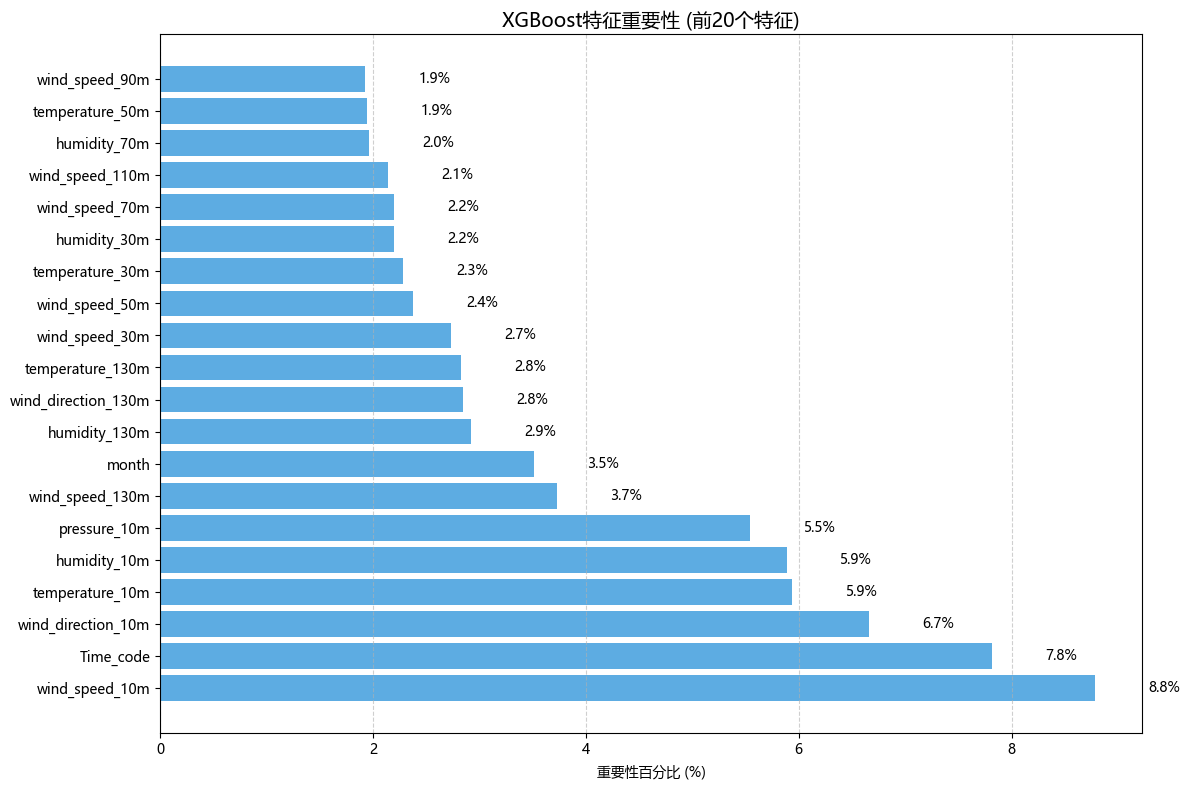

前10个最重要的特征:
1. wind_speed_10m: 8.79%
2. Time_code: 7.81%
3. wind_direction_10m: 6.66%
4. temperature_10m: 5.94%
5. humidity_10m: 5.89%
6. pressure_10m: 5.55%
7. wind_speed_130m: 3.73%
8. month: 3.51%
9. humidity_130m: 2.92%
10. wind_direction_130m: 2.84%


In [26]:
best_model  = model
# 获取特征重要性
importance = best_model.get_booster().get_score(importance_type='weight')

# 将特征重要性转换为百分比并排序
total_importance = sum(importance.values())
importance_percent = {k: (v / total_importance) * 100 for k, v in importance.items()}
importance_sorted = dict(sorted(importance_percent.items(), key=lambda item: item[1], reverse=True))

# 创建一个更美观的特征重要性图
plt.figure(figsize=(12, 8))
features = list(importance_sorted.keys())[:20]  # 取前20个特征
values = [importance_sorted[feature] for feature in features]

# 创建水平条形图
bars = plt.barh(range(len(features)), values, align='center', color='#3498db', alpha=0.8)
plt.yticks(range(len(features)), features)
plt.xlabel('重要性百分比 (%)')
plt.title('XGBoost特征重要性 (前20个特征)', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# 在条形上添加百分比标签
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{values[i]:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# 保存特征重要性数据到CSV文件
importance_df = pd.DataFrame({
    '特征': list(importance_sorted.keys()),
    '重要性(%)': list(importance_sorted.values())
})
importance_df.to_csv('feature_importance.csv', index=False, encoding='utf-8-sig')

# 打印前10个最重要的特征
print("前10个最重要的特征:")
for i, (feature, value) in enumerate(list(importance_sorted.items())[:10]):
    print(f"{i+1}. {feature}: {value:.2f}%")

## 按月份作图

In [13]:
for month, group in year_month_groups:
                
        train_sets = []
        test_sets = []

        last_ten_days = group.iloc[-960:].dropna()
        test_sets.append(last_ten_days)
        train_sets.append(group.iloc[:-960].dropna())

        # 合并当前文件的所有月的最后五天数据
        test_sets_A1 = pd.concat(test_sets)
        train_sets_A1= pd.concat(train_sets)


        X_train1 = train_sets_A1.loc[:,['wind_speed_10m', 'wind_direction_10m', 'temperature_10m',
                'humidity_10m', 'pressure_10m', 'wind_speed_30m', 'wind_direction_30m',
                'temperature_30m', 'humidity_30m', 'pressure_30m', 'wind_speed_50m',
                'wind_direction_50m', 'temperature_50m', 'humidity_50m', 'pressure_50m',
                'wind_speed_70m', 'wind_direction_70m', 'temperature_70m',
                'humidity_70m', 'pressure_70m', 'wind_speed_90m', 'wind_direction_90m',
                'temperature_90m', 'humidity_90m', 'pressure_90m', 'wind_speed_110m',
                'wind_direction_110m', 'temperature_110m', 'humidity_110m',
                'pressure_110m', 'wind_speed_130m', 'wind_direction_130m',
                'temperature_130m', 'humidity_130m', 'pressure_130m','month', 'Time_code']]
        y_train1  = train_sets_A1.loc[:, ['power']]
        X_test1 = test_sets_A1.loc[:,['wind_speed_10m', 'wind_direction_10m', 'temperature_10m',
                'humidity_10m', 'pressure_10m', 'wind_speed_30m', 'wind_direction_30m',
                'temperature_30m', 'humidity_30m', 'pressure_30m', 'wind_speed_50m',
                'wind_direction_50m', 'temperature_50m', 'humidity_50m', 'pressure_50m',
                'wind_speed_70m', 'wind_direction_70m', 'temperature_70m',
                'humidity_70m', 'pressure_70m', 'wind_speed_90m', 'wind_direction_90m',
                'temperature_90m', 'humidity_90m', 'pressure_90m', 'wind_speed_110m',
                'wind_direction_110m', 'temperature_110m', 'humidity_110m',
                'pressure_110m', 'wind_speed_130m', 'wind_direction_130m',
                'temperature_130m', 'humidity_130m', 'pressure_130m','month', 'Time_code']]
        y_test1 = test_sets_A1.loc[:, ['power']]


        X_train1, y_train1, X_test1, y_test1

        wind_speed_10m_train = train_sets_A1.loc[:,['wind_speed_10m']]
        wind_speed_10m_test = test_sets_A1.loc[:,['wind_speed_10m']]

        xr_sw_train = train_sets_A1.loc[:,['power_xr']]
        xr_sw_test = test_sets_A1.loc[:,['power_xr']]

        X = pd.concat([X_train1,X_test1])
        y = pd.concat([y_train1,y_test1]).values.flatten()

        wind_speed_10m = pd.concat([wind_speed_10m_train,wind_speed_10m_test]).values.flatten()
        xr_sw = pd.concat([xr_sw_train,xr_sw_test]).values.flatten()

        # 创建一个包含两个子图的图表
        fig, axes = plt.subplots(2, 1, figsize=(16, 8), dpi=300)
        d_train = X
        # 第一个子图：XGBoost模型预测结果
        axes[0].plot(range(len(X.index.tolist())), model.predict(d_train), color='red', label='XGBoost预测值')
        axes[0].plot(range(len(X.index.tolist())), xr_sw, color='blue', alpha=0.5, label='xr预测值')
        axes[0].scatter(range(len(X.index.tolist())), y, color='black', marker='o', s=2.0, label='实际功率')
        axes[0].grid(True)
        axes[0].set_title(f'{str(month)}月功率预测', fontsize=20)
        axes[0].set_xlabel('时间(15min)')
        axes[0].set_ylabel('功率')
        axes[0].set_xlim(0, 3000)
        predict = model.predict(d_train)
        # 计算第一个子图的评估指标
        mse = mean_squared_error(predict[-960:], y[-960:]) 
        mse_xr = mean_squared_error(xr_sw[-960:], y[-960:]) 
        rmse = np.sqrt(mean_squared_error(predict[-960:], y[-960:])) 
        rmse_xr = np.sqrt(mean_squared_error(xr_sw[-960:], y[-960:])) 
        r = pearson_correlation_coefficient(predict[-960:], y[-960:]) 
        r_xr = pearson_correlation_coefficient(xr_sw[-960:], y[-960:])
        mbias = np.sum(predict[-960:] - y[-960:])/len(y[-960:]) 
        mbias_xr = np.sum(xr_sw[-960:] - y[-960:])/len(y[-960:]) 
        # 创建评估指标数据字典 
        metrics_data = { 
                'Month': [month], 
                'Linj_MSE': [mse], 
                'XR_MSE': [mse_xr], 
                'Linj_RMSE': [rmse], 
                'XR_RMSE': [rmse_xr], 
                'Linj_R': [r], 
                'XR_R': [r_xr], 
                'Linj_MBias': [mbias], 
                'XR_MBias': [mbias_xr] 
        } 
        # 创建DataFrame并保存到CSV 
        metrics_df = pd.DataFrame(metrics_data) 

       # 检查文件是否存在 
        csv_path = 'site_linj_compare_XR.csv' 
        if os.path.exists(csv_path): 
                # 读取已有的CSV文件 
                existing_df = pd.read_csv(csv_path) 
                # 检查当前月份是否已存在
                current_month = metrics_df['Month'].iloc[0]  # 获取当前月份值
                
                # 确保类型一致进行比较
                existing_months = existing_df['Month'].astype(str).values
                current_month_str = str(current_month)
                
                if current_month_str not in existing_months:
                        # 如果月份不存在，则追加数据 
                        metrics_df.to_csv(csv_path, mode='a', header=False, index=False) 
                else:
                        print(f"月份 {current_month} 的数据已存在，跳过追加")
        else: 
                # 如果文件不存在，创建新文件 
                metrics_df.to_csv(csv_path, index=False)
        # 在右上角添加指标文本 
        # 生成Linj模型的评估指标文本 
        linj_textstr = '    '.join((f'Linj R: {r:.2f}',f'Linj MSE: {mse:.2f}',f'Linj RMSE: {rmse:.2f}',f'Linj MBias: {mbias:.2f}' )) 
        # 生成ph模型的评估指标文本 
        xr_textstr = '    '.join((f'XR R: {r_xr:.2f}',f'XR MSE: {mse_xr:.2f}',f'XR RMSE: {rmse_xr:.2f}',f'XR MBias: {mbias_xr:.2f}' )) 
        # 合并两行评估指标 
        textstr = linj_textstr + '\n' + xr_textstr
        axes[0].text(0.95, 0.95, textstr, transform=axes[0].transAxes,
                    fontsize=15, verticalalignment='top', horizontalalignment='right', color='darkred',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        # 在第一个子图中标记测试集区域
        start_idx = len(X) - 960
        end_idx = len(X)
        axes[0].axvspan(start_idx, end_idx-1, color='#919193', alpha=0.3, label='测试集(最后10天)')
        axes[0].legend(loc='upper left')
        
        # 第二个子图：辐射值对比
        axes[1].plot(range(len(X.index.tolist())), X['wind_speed_10m'], color='red', label='预测10m风速值')
        axes[1].scatter(range(len(X.index.tolist())), xr_sw, color='black', marker='o', s=2.0, label='实际10m风速值')
        axes[1].grid(True)
        axes[1].set_title(f'{str(month)}月10m风速值对比', fontsize=20)
        axes[1].set_xlabel('时间(15min)')
        axes[1].set_ylabel('10m风速值')
        axes[1].set_xlim(0, 3000)
        
        # 计算第二个子图的评估指标
        predict = X['wind_speed_10m']
        mse = mean_squared_error(predict[-960:], xr_sw[-960:])
        rmse = np.sqrt(mean_squared_error(predict[-960:], xr_sw[-960:]))
        r = pearson_correlation_coefficient(predict[-960:], xr_sw[-960:])
        mbias = np.sum(predict[-960:] - xr_sw[-960:]) / len(xr_sw[-960:])
        
        # 在第二个子图右上角添加指标文本
        textstr = '    '.join((f'R: {r:.2f}', f'MSE: {mse:.2f}', f'RMSE: {rmse:.2f}', f'MBias: {mbias:.2f}'))
        axes[1].text(0.95, 0.95, textstr, transform=axes[1].transAxes,
                    fontsize=15, verticalalignment='top', horizontalalignment='right', color='#1362b7',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        # 在第二个子图中标记测试集区域
        axes[1].axvspan(start_idx, end_idx-1, color='#919193', alpha=0.3, label='测试集(最后10天)')
        axes[1].legend(loc='upper left')
        
        # 调整子图之间的间距
        plt.tight_layout()
        
        # 保存图表
        save_dir = 'xgb_fig_xr_merge'
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, f"combined_{str(month)}.png"), dpi=300, format='png', bbox_inches='tight', pad_inches=0)
        plt.show()

NameError: name 'year_month_groups' is not defined

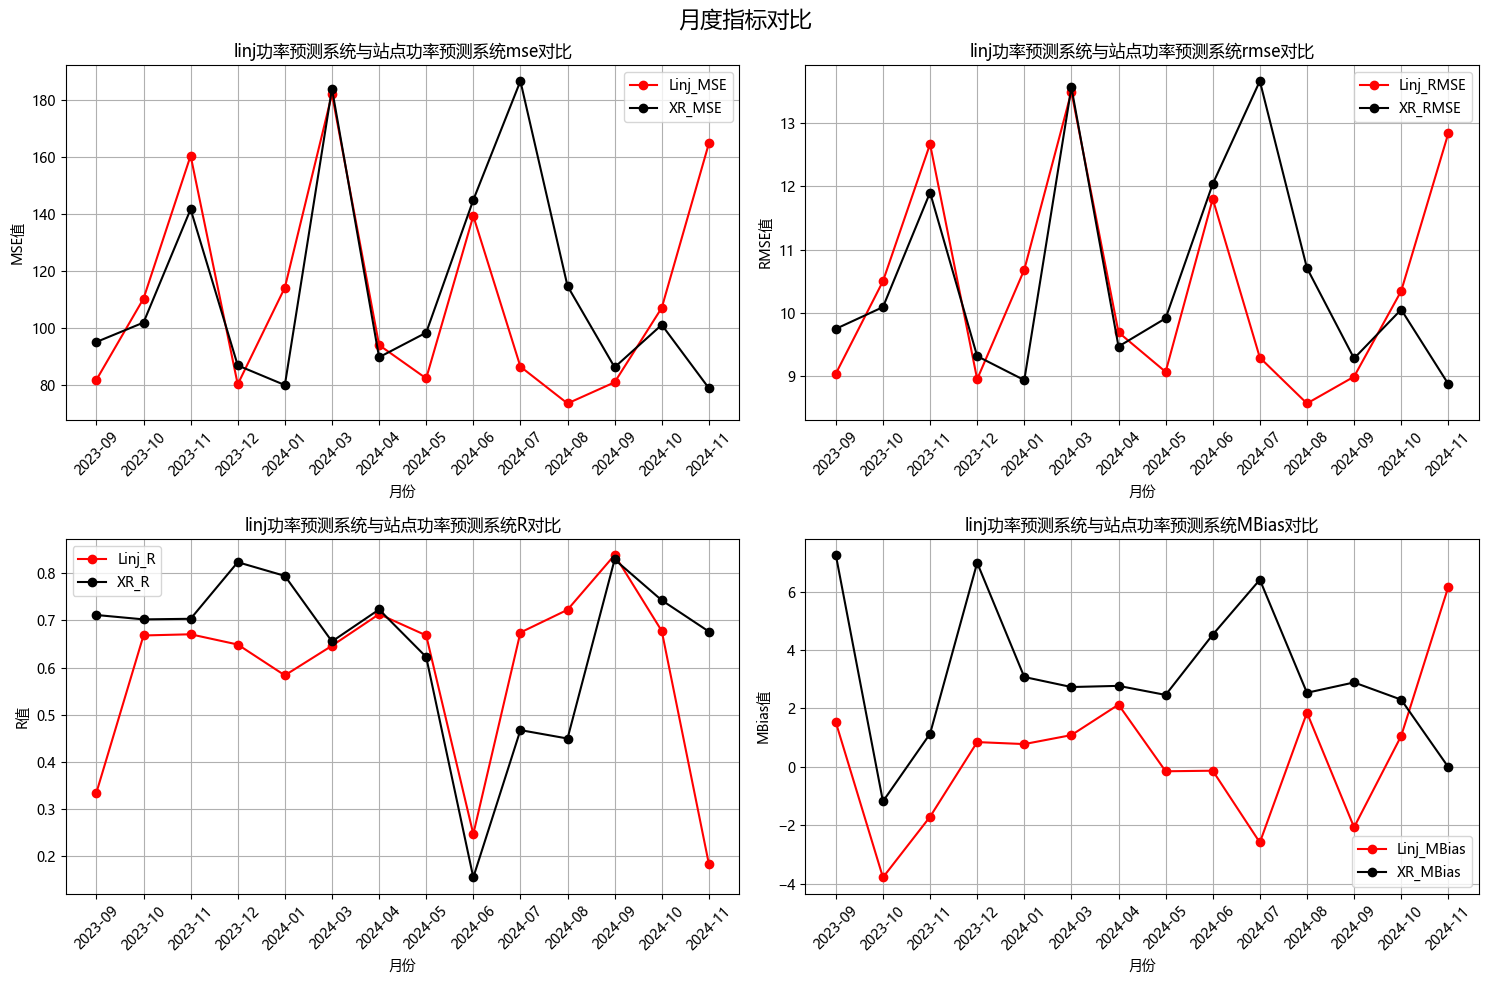

In [14]:
file_path = r'E:\Power_Pre_Model\site_linj_compare_XR.csv'

# 读取数据（假设数据分隔符为空格）
total_df = pd.read_csv(
    file_path,
    header=0,
    low_memory=False,
)

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('月度指标对比', fontsize=16)

# 绘制第一个子图 - mse对比
axes[0,0].plot(total_df['Month'], total_df['Linj_MSE'], marker='o',label='Linj_MSE',color='red')
axes[0,0].plot(total_df['Month'], total_df['XR_MSE'], marker='o',label='XR_MSE',color='black')
axes[0,0].set_title('linj功率预测系统与站点功率预测系统mse对比')
axes[0,0].set_xlabel('月份')
axes[0,0].set_ylabel('MSE值')
axes[0,0].legend()
plt.setp(axes[0,0].get_xticklabels(), rotation=45)

axes[0,0].grid(True)

# 绘制第二个子图 - RMSE对比
axes[0,1].plot(total_df['Month'], total_df['Linj_RMSE'], marker='o',label='Linj_RMSE',color='red')
axes[0,1].plot(total_df['Month'], total_df['XR_RMSE'], marker='o',label='XR_RMSE',color='black')
axes[0,1].set_title('linj功率预测系统与站点功率预测系统rmse对比')
axes[0,1].set_xlabel('月份')
axes[0,1].set_ylabel('RMSE值')
axes[0,1].legend()
plt.setp(axes[0,1].get_xticklabels(), rotation=45)
axes[0,1].grid(True)

# 绘制第三个子图 - R对比
axes[1,0].plot(total_df['Month'], total_df['Linj_R'], marker='o',label='Linj_R',color='red')
axes[1,0].plot(total_df['Month'], total_df['XR_R'], marker='o',label='XR_R',color='black')
axes[1,0].set_title('linj功率预测系统与站点功率预测系统R对比')
axes[1,0].set_xlabel('月份')
axes[1,0].set_ylabel('R值')
axes[1,0].legend()
plt.setp(axes[1,0].get_xticklabels(), rotation=45)
axes[1,0].grid(True)

# 绘制第四个子图 - 预测PR
axes[1,1].plot(total_df['Month'], total_df['Linj_MBias'], marker='o',label='Linj_MBias',color='red')
axes[1,1].plot(total_df['Month'], total_df['XR_MBias'], marker='o',label='XR_MBias',color='black')
axes[1,1].set_title('linj功率预测系统与站点功率预测系统MBias对比')
axes[1,1].set_xlabel('月份')
axes[1,1].set_ylabel('MBias值')
axes[1,1].legend()
plt.setp(axes[1,1].get_xticklabels(), rotation=45)
axes[1,1].grid(True)

# 调整子图布局
plt.tight_layout()

save_dir = 'month_compare_xr'
os.makedirs(save_dir, exist_ok=True)  # 创建保存目录，若不存在则创建
plt.savefig(os.path.join(save_dir, f"month_compare_xr.png"), dpi=500, format='png', bbox_inches='tight', pad_inches=0)

plt.show()
